# Detecting Fake News in Tweets

## Table of Contents

- <a href = #Imports> Imports </a>
- <a href = #DataExploration>  Data Exploration & Feature Engineering</a>
     - <a href = #NumericData>  Numeric Data  </a>
         - <a href = #Scaling> Scaling </a>
         - <a href = #FrequencyComparrisons>  Frequency Comparrisons </a> 
     - <a href = #TextualData>  Textual Data  </a>
        - <a href = #UserDescription> User Description/ Text Body Length</a>
        - <a href = #Vocab>  Vocab </a>
        - <a href = #Hashtags>  Hashtags  </a>
        - <a href = #UserMentions> User Mentions </a>
        - <a href = #Punctuation> Punctuation Analysis </a>
        - <a href = #Retweet>Retweets </a>
        - <a href = #URLs> URLs </a>
            - <a href = #URLAnalysis> URL Analysis </a>
        - <a href = #Dates> Dates </a>
- <a href = #TextPreprocessing> Text Preprocessing </a>
- <a href = #FeatureSelection> Feature Selection </a>
    - <a href = #Upsampling> Upsampling </a>
    - <a href = #Chi-Square> Chi-Square </a>
    - <a href = #PCA> PCA </a>
- <a href = #ModelSelection> Model Selection </a>
    -  <a href = #MLP> MLP </a>
        -  <a href = #Keras> Keras </a>
        -  <a href = #Sci-kitLearn> Sci-kit Learn </a>
    -  <a href = #SVM> SVM </a>
    -  <a href = #DecisionTree> Decision Tree </a>
    - <a href = #RandomForest>  Random forest </a>
- <a href = #Hyperparameter> Hyperparameter tuning w/ GridSearch </a>
    - <a href = #SVM2> SVM </a>
    - <a href = #MLP2> MLP </a>
- <a href = #FalsePositive> False positive/ negative analysis </a>

<a name='Imports' /> 

## Library and Data Imports

In [ ]:
#imports
import keras
import pandas as pd
import seaborn as sns
import numpy as np
import re
import spacy
import nltk
import requests
import string
import pickle
import matplotlib.pyplot as plt 

!pip install lime
from lime import lime_text
import datetime
from dateutil import parser
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_selection, feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS 
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output


pd.options.mode.chained_assignment = None  # default='warn'
stopwords = STOP_WORDS
nlp = spacy.load('en')
text_parser = English()
nltk.download('words')
words = set(nltk.corpus.words.words())
punctuations = string.punctuation

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#LETS MOUNT OUR DATA

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_raw_1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/training.csv")
data_raw_2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/training_1.csv")
data_raw_3= pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/training_2.csv")
data_raw = pd.concat([data_raw_1,data_raw_3,data_raw_2])
data_raw = data_raw.reset_index(drop=True)
print(len(data_raw.columns))
print(len(data_raw))
data_raw.head(2)

31
29738


tweet_id      user_name  ... Tweet_favorites label
0  1101696443813908480  davepowersNYC  ...             0.0   0.0
1  1180294427958501376   Katty_Kissem  ...             0.0   1.0

[2 rows x 31 columns]

In [ ]:
#data_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/training_full.csv")
#data_raw = data_raw.drop(data_raw.columns[[0, 1]], axis=1)
#data_raw = data_raw.reset_index(drop=True)
#data_raw.head(2)

In [ ]:
#data_raw.to_csv("/content/drive/My Drive/Colab Notebooks/data/training_full.csv")

## Data Exploration & Feature Engineering

### Remove retweet duplicate data

In [ ]:
#extract the non duplicate text rows from the concat info
data_raw = data_raw[~data_raw["text"].duplicated(keep="first")].reset_index(drop=True)

In [ ]:
data_raw.shape

(7665, 31)

In [ ]:
#remove na labels (move code to here rather than in seperate sections)

### Class imbalance

In [ ]:
data_raw["label"].value_counts()

0.0    4199
1.0    3462
Name: label, dtype: int64

In [ ]:
data_raw["label"].mean()

0.4518992298655528

We can't look at correlations using the label mean until the dataset is balanced, as there are far more "real information" tweets that skew the mean towards 0

### Null value vizualisation



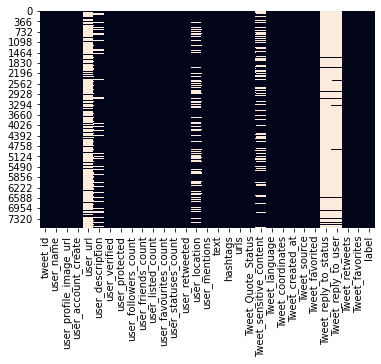

In [ ]:
sns.heatmap(data_raw.isnull(), cbar=False)

### Retweeted

In [ ]:
data_raw["user_retweeted"].value_counts()

False                                                       5400
False                                                       2263
https://www.theblaze.com/facebook-suspends-candace-owens       1
Name: user_retweeted, dtype: int64

### Quote status

In [ ]:
data_raw["Tweet_Quote_Status"].value_counts()

False                  3160
False                  2832
True                   1036
True                    633
Twitter for Android       1
Name: Tweet_Quote_Status, dtype: int64

### Sensitive content

In [ ]:
data_raw["Tweet_sensitive_content"].value_counts()

False    5416
True      141
Name: Tweet_sensitive_content, dtype: int64

### Favorited Tweet

In [ ]:
data_raw["Tweet_favorited"].value_counts()

False    4196
False    3465
0           1
Name: Tweet_favorited, dtype: int64

### Verified User

In [ ]:
data_raw["user_verified"].value_counts()

False    5322
False    2224
True       78
True       39
52575       1
Name: user_verified, dtype: int64

### Sensitive Tweet

In [ ]:
data_raw["Tweet_sensitive_content"].value_counts()

False    5416
True      141
Name: Tweet_sensitive_content, dtype: int64

## Initial feature selection

### All features we want to use

In [ ]:
data_raw_features = data_raw[["user_name","user_account_create","user_description","user_verified","user_followers_count","user_friends_count","user_listed_count","user_favourites_count","user_statuses_count","user_location","text","hashtags","urls","Tweet_Quote_Status","Tweet_sensitive_content",
                              "Tweet_created_at","Tweet_retweets","label"]]

### Numeric features

In [ ]:
data_raw_numeric = data_raw_features[["user_followers_count","user_friends_count","user_listed_count","user_favourites_count","user_statuses_count","Tweet_retweets","label"]]

### Text features

In [ ]:
data_raw_text = data_raw[["user_name","user_account_create","user_description","text","hashtags","label"]]

<a name='NumericData' />

 ## Numeric Feautre Exploration

In [ ]:
data_raw_numeric.head()

user_followers_count user_friends_count  ... Tweet_retweets label
0                  827                170  ...         1920.0   0.0
1                  568               1057  ...         6528.0   1.0
2                 1887               1691  ...            1.0   0.0
3                 1202               1887  ...         2558.0   0.0
4                 4089               4075  ...            2.0   0.0

[5 rows x 7 columns]

In [ ]:
data_raw_numeric.dtypes

user_followers_count      object
user_friends_count        object
user_listed_count         object
user_favourites_count     object
user_statuses_count       object
Tweet_retweets           float64
label                    float64
dtype: object

In [ ]:
data_raw_numeric = data_raw_numeric.apply(pd.to_numeric, errors='coerce')

In [ ]:
data_raw_numeric.median()

user_followers_count      1745.0
user_friends_count        2118.0
user_listed_count            6.0
user_favourites_count    29560.0
user_statuses_count      45300.0
Tweet_retweets               3.0
label                        0.0
dtype: float64

In [ ]:
data_raw_numeric.mean()

user_followers_count     19744.969464
user_friends_count        5430.303275
user_listed_count          127.860759
user_favourites_count    60998.302492
user_statuses_count      86975.438210
Tweet_retweets             255.496019
label                        0.451899
dtype: float64

In [ ]:
data_raw_numeric.isna().sum()

user_followers_count     2
user_friends_count       2
user_listed_count        2
user_favourites_count    2
user_statuses_count      2
Tweet_retweets           4
label                    4
dtype: int64

Fill missing values with medians - except label (drop those)

In [ ]:
data_raw_numeric = data_raw_numeric[data_raw_numeric['label'].notna()]
data_raw_numeric.reset_index(inplace=True,drop=True)

In [ ]:
len(data_raw_numeric)

7661

In [ ]:
data_raw_numeric = data_raw_numeric.fillna(data_raw_numeric.median())

In [ ]:
data_raw_numeric.isna().sum()

user_followers_count     0
user_friends_count       0
user_listed_count        0
user_favourites_count    0
user_statuses_count      0
Tweet_retweets           0
label                    0
dtype: int64

In [ ]:
data_raw_numeric.max()

user_followers_count     45251322.0
user_friends_count         163748.0
user_listed_count          203424.0
user_favourites_count     1327797.0
user_statuses_count       1564874.0
Tweet_retweets              37936.0
label                           1.0
dtype: float64

In [ ]:
data_raw_numeric.min()

user_followers_count     0.0
user_friends_count       0.0
user_listed_count        0.0
user_favourites_count    0.0
user_statuses_count      9.0
Tweet_retweets           0.0
label                    0.0
dtype: float64

In [ ]:
data_raw_numeric.median()

user_followers_count      1749.0
user_friends_count        2119.0
user_listed_count            6.0
user_favourites_count    29599.0
user_statuses_count      45326.0
Tweet_retweets               3.0
label                        0.0
dtype: float64

In [ ]:
data_raw_numeric.mean()

user_followers_count     19750.119436
user_friends_count        5431.720924
user_listed_count          127.894139
user_favourites_count    61014.226863
user_statuses_count      86992.913719
Tweet_retweets             255.496019
label                        0.451899
dtype: float64

In [ ]:
data_raw_numeric.describe()

user_followers_count  user_friends_count  ...  Tweet_retweets        label
count          7.661000e+03         7661.000000  ...     7661.000000  7661.000000
mean           1.975012e+04         5431.720924  ...      255.496019     0.451899
std            7.342765e+05        10747.639658  ...     1189.940759     0.497713
min            0.000000e+00            0.000000  ...        0.000000     0.000000
25%            3.750000e+02          525.000000  ...        0.000000     0.000000
50%            1.749000e+03         2119.000000  ...        3.000000     0.000000
75%            5.336000e+03         4999.000000  ...       49.000000     1.000000
max            4.525132e+07       163748.000000  ...    37936.000000     1.000000

[8 rows x 7 columns]

In [ ]:
data_raw_numeric.corr()

user_followers_count  ...     label
user_followers_count               1.000000  ...  0.019232
user_friends_count                 0.009898  ... -0.049438
user_listed_count                  0.993553  ...  0.024212
user_favourites_count             -0.005649  ...  0.022336
user_statuses_count                0.045640  ... -0.046807
Tweet_retweets                     0.003682  ...  0.200650
label                              0.019232  ...  1.000000

[7 rows x 7 columns]

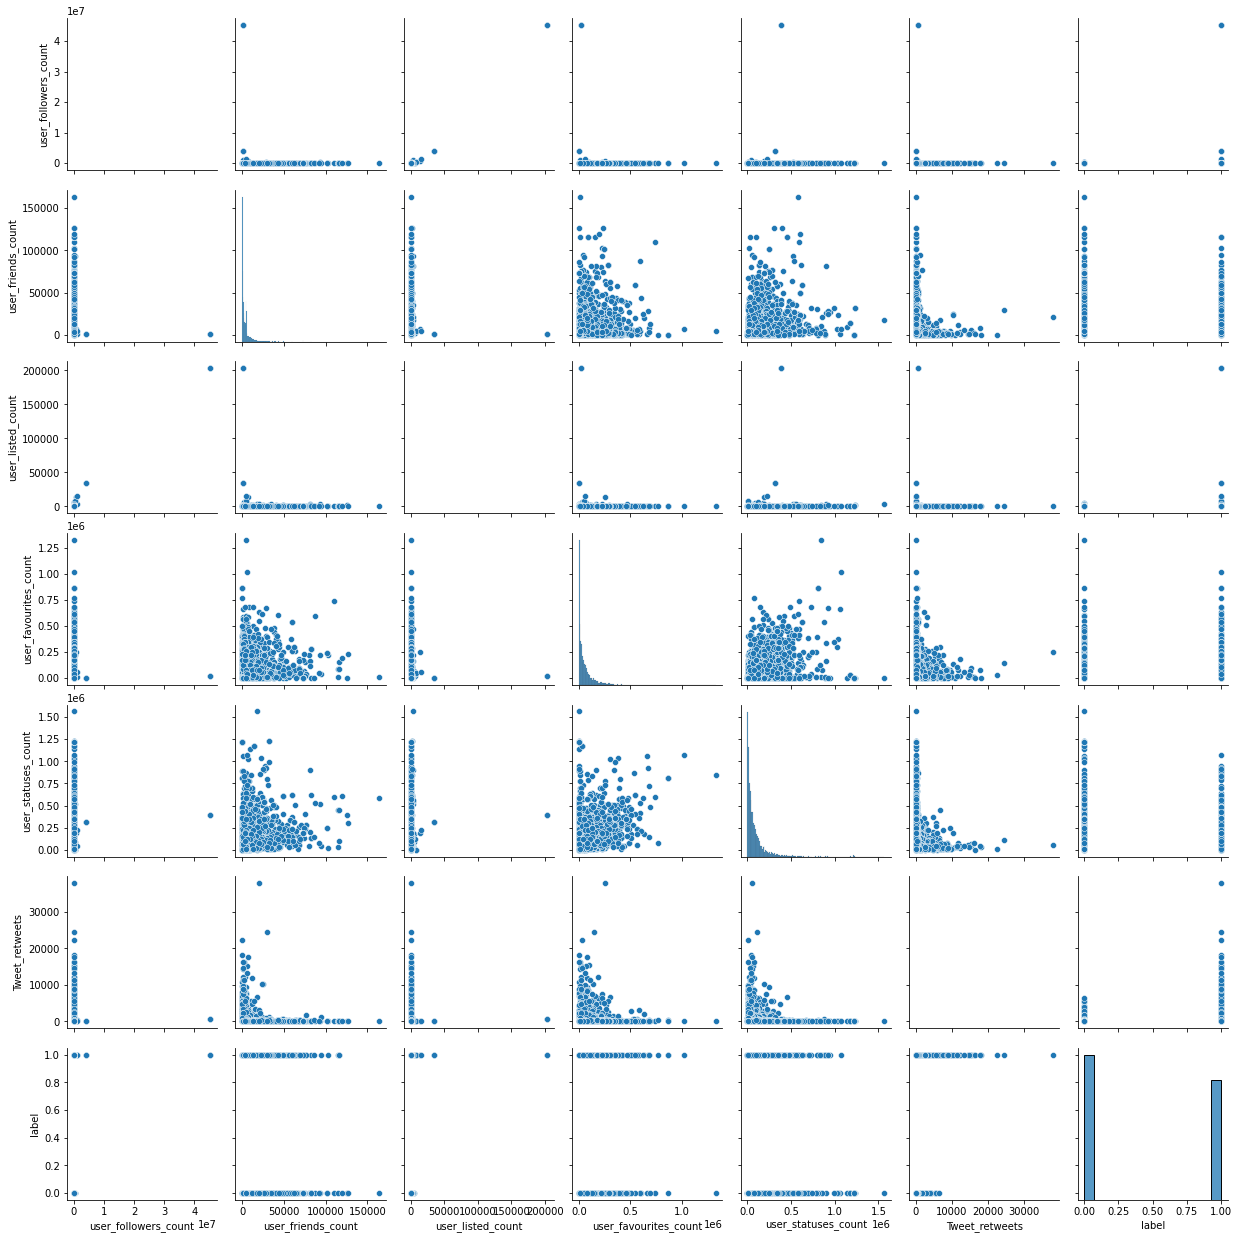

In [ ]:
sns.pairplot(data_raw_numeric)

<a name='Scaling' />

### Scaling

This might be easier to understand if we scaled the data

In [ ]:
data_raw_numeric_logged = np.log2(data_raw_numeric.loc
                                        [:, data_raw_numeric.columns != "label"]
                                        .replace(0, np.nan))

In [ ]:
data_raw_numeric_logged = data_raw_numeric_logged.fillna(0)

In [ ]:
data_raw_numeric_logged["label"] = data_raw_numeric["label"]

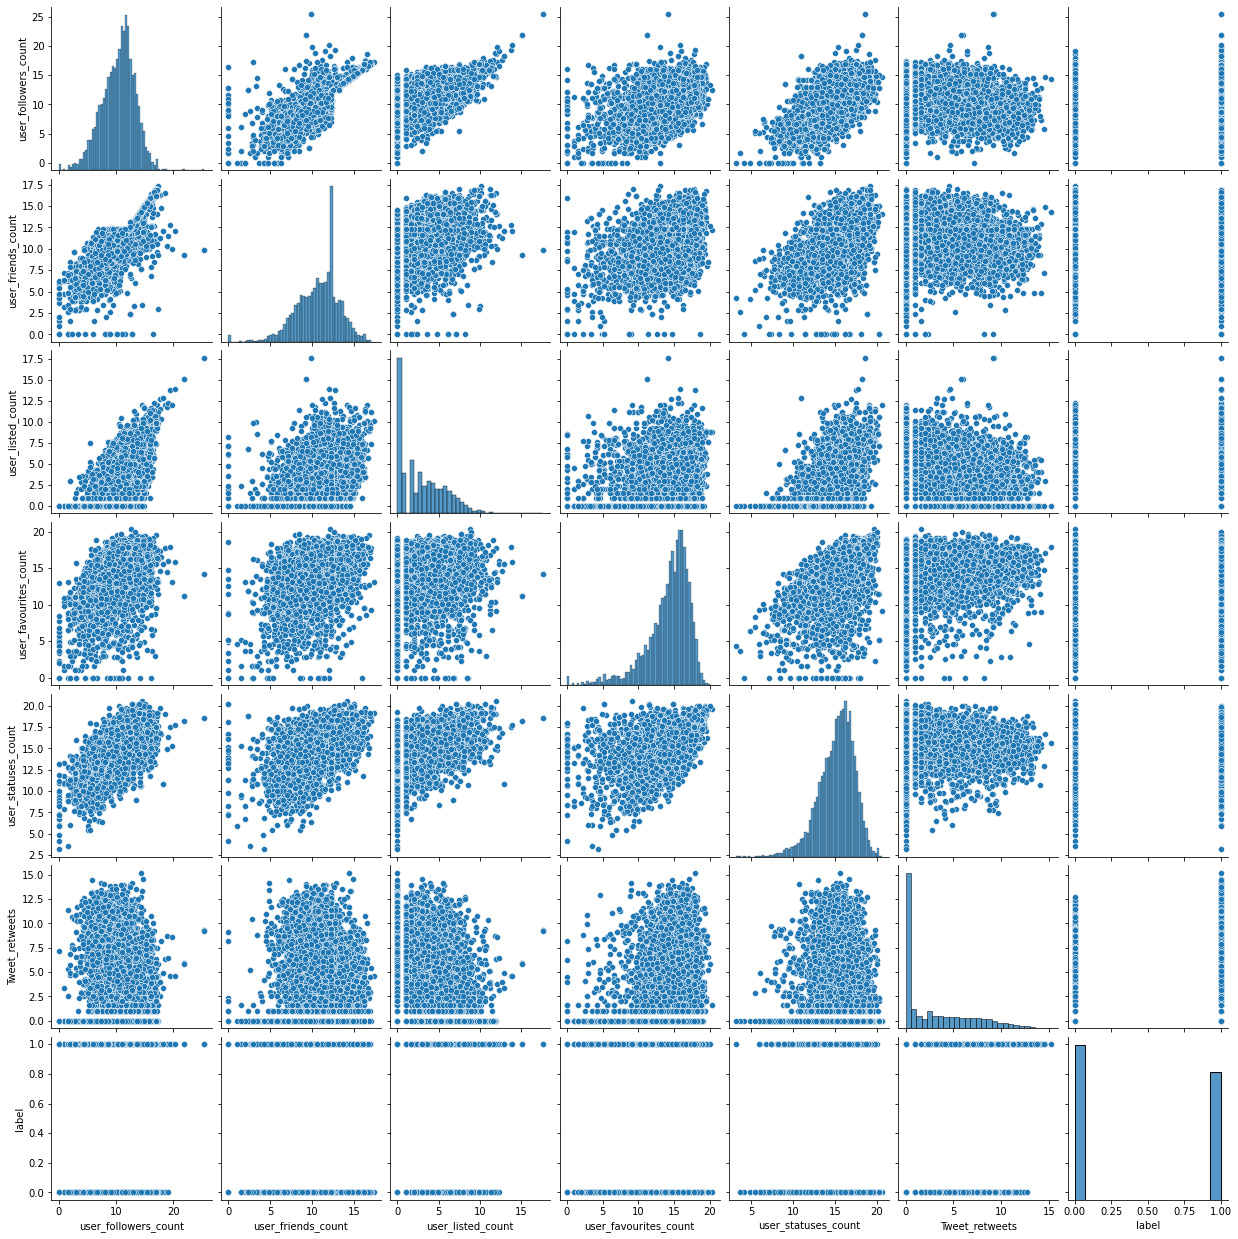

In [ ]:
sns.pairplot(data_raw_numeric_logged)

In [ ]:
data_raw_numeric_logged.head()

user_followers_count  user_friends_count  ...  Tweet_retweets  label
0              9.691744            7.409391  ...       10.906891    0.0
1              9.149747           10.045760  ...       12.672425    1.0
2             10.881879           10.723661  ...        0.000000    0.0
3             10.231221           10.881879  ...       11.320801    0.0
4             11.997532           11.992584  ...        1.000000    0.0

[5 rows x 7 columns]

Upsample smaller class before doing frequency based comparrisons:

In [ ]:
misinformation = data_raw_numeric_logged[data_raw_numeric_logged["label"]==1]
realinformation = data_raw_numeric_logged[data_raw_numeric_logged["label"]==0]
print(len(misinformation), len(realinformation))

3462 4199


In [ ]:
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

In [ ]:
print(len(misinformation), len(realinformation))

4199 4199


<a name='FrequencyComparrisons' />

### Frequency comparrisons

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


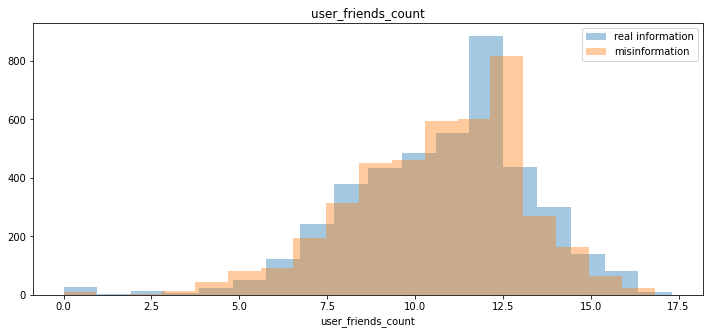

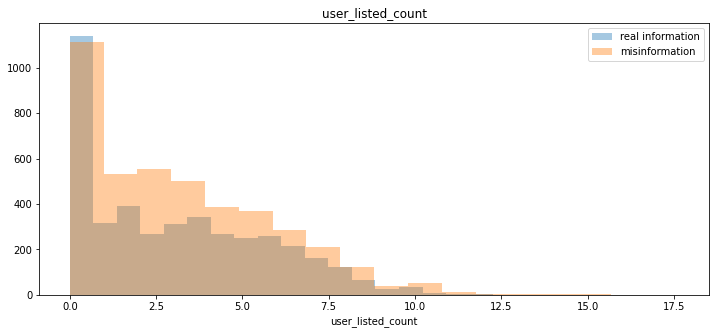

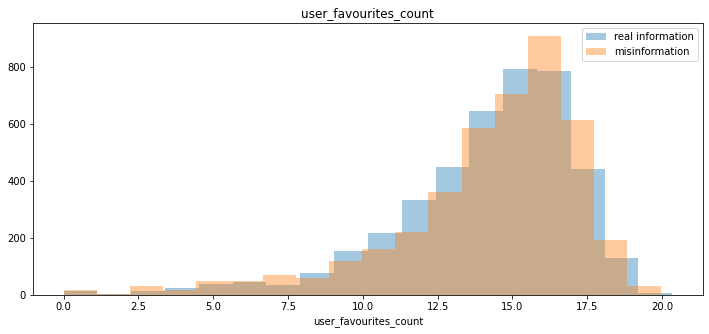

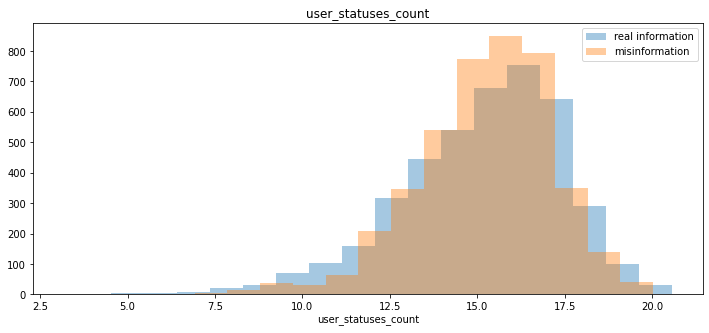

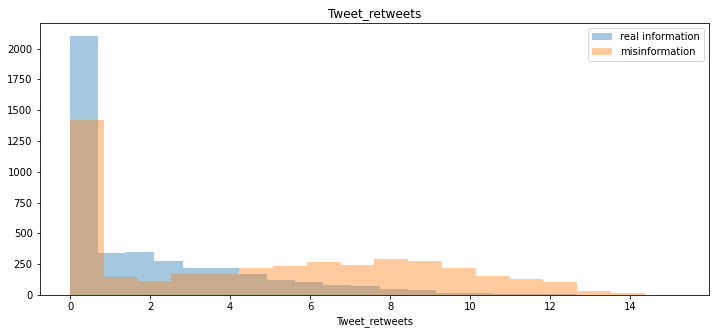

In [ ]:
for col in data_raw_numeric.columns[1:-1]:
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,5))
    ax = sns.distplot( realinformation[col] , label = 'real information', bins=18,  kde =False)
    ax = sns.distplot( misinformation[col] , label = 'misinformation', bins=18, kde =False)
    ax.legend()
    _=ax.set_title(col)
    
    

There doesnt seem to be that much correlation between frequencies of certain values and whether they are real information or not!

In [ ]:
scaler = MinMaxScaler()
data_raw_numeric_logged_scaled = pd.DataFrame(scaler.fit_transform(data_raw_numeric_logged), 
                                              columns = data_raw_numeric_logged.columns)

In [ ]:
data_raw_numeric_logged_scaled.head()

user_followers_count  user_friends_count  ...  Tweet_retweets  label
0              0.381093            0.427766  ...        0.717026    0.0
1              0.359781            0.579972  ...        0.833094    1.0
2              0.427891            0.619109  ...        0.000000    0.0
3              0.402306            0.628243  ...        0.744237    0.0
4              0.471760            0.692368  ...        0.065741    0.0

[5 rows x 7 columns]

We've got our numerical data ready to be consumed by a model, now lets look at the textual data

## Numeric Feature Interpretability

In this section we use Captum to vizualise inside the neural network to see how the individual neurones/ layers contributed to the outcome

In [ ]:
!pip install captum

     |████████████████████████████████| 5.7MB 10.1MB/s 


In [ ]:
data_s = data_raw_numeric_logged_scaled

In [ ]:
data_s = data_s[0:10000]

In [ ]:
len(data_s)

7661

In [ ]:
data_s

user_followers_count  user_friends_count  ...  Tweet_retweets  label
0                 0.381093            0.427766  ...        0.717026    0.0
1                 0.359781            0.579972  ...        0.833094    1.0
2                 0.427891            0.619109  ...        0.000000    0.0
3                 0.402306            0.628243  ...        0.744237    0.0
4                 0.471760            0.692368  ...        0.065741    0.0
...                    ...                 ...  ...             ...    ...
7656              0.402729            0.564991  ...        0.000000    1.0
7657              0.487367            0.722540  ...        0.065741    1.0
7658              0.408977            0.670525  ...        0.521372    1.0
7659              0.454078            0.709290  ...        0.000000    0.0
7660              0.434709            0.683808  ...        0.000000    1.0

[7661 rows x 7 columns]

In [ ]:
# Set random seed for reproducibility.
np.random.seed(1)

# Convert features and labels to numpy arrays.
labels = data_s["label"].to_numpy()
data = data_s.drop(['label'], axis=1)
feature_names = list(data.columns)

#scale
data = scaler.fit_transform(data)

#data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices].astype(int)
test_features = data[test_indices]
test_labels = labels[test_indices].astype(int)

In [ ]:
no_features = len(data[0])
no_classes = 2
no_features

6

In [ ]:
len(data[0])

6

In [ ]:
type(train_labels)

numpy.ndarray

In [ ]:
type(train_labels[0])

numpy.int64

In [ ]:
train_labels.astype(int)

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # for reproducibility.

nb_input = no_features
nb_output = no_classes

class TweetSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(nb_input, 7)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(7, 6)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(6, no_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [ ]:
#shuld already be mounted..
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
train_features.shape

(5362, 6)

In [ ]:
test_features.shape

(2299, 6)

In [ ]:
train_labels.shape

(5362,)

In [ ]:
net = TweetSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/tweet_interpret_pt.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200


    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch, num_epochs, loss.item()))

    torch.save(net.state_dict(), '/content/drive/My Drive/Colab Notebooks/Models/tweet_interpret_pt.pt')

Epoch 0/200 => Loss: 0.69
Epoch 20/200 => Loss: 0.68
Epoch 40/200 => Loss: 0.61
Epoch 60/200 => Loss: 0.60
Epoch 80/200 => Loss: 0.60
Epoch 100/200 => Loss: 0.59
Epoch 120/200 => Loss: 0.58
Epoch 140/200 => Loss: 0.58
Epoch 160/200 => Loss: 0.58
Epoch 180/200 => Loss: 0.58


In [ ]:
#batch_size = 5
#nb_classes = 2
#in_features = 10#
#
#model = nn.Linear(in_features, nb_classes)
##criterion = nn.CrossEntropyLoss()###
#
#x = torch.randn(batch_size, in_features)
##target = torch.empty(batch_size, dtype=torch.long).random_(nb_classes)###
#
#output = model(x)
##loss = criterion(output, target)
#loss.backward()

In [ ]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.7232375979112271


In [ ]:
zip(out_probs,out_classes)

In [ ]:
pd.DataFrame(zip(out_probs,out_classes,train_labels))

0  1  2
0     [0.97911865, 0.020881325]  0  1
1       [0.45594862, 0.5440514]  1  0
2      [0.9837969, 0.016203139]  0  0
3      [0.83320665, 0.16679333]  0  1
4      [0.006613331, 0.9933867]  1  0
...                         ... .. ..
5357    [0.7526314, 0.24736853]  0  0
5358   [0.9211627, 0.078837276]  0  0
5359   [0.02922137, 0.97077864]  1  1
5360   [0.002809285, 0.9971908]  1  1
5361     [0.8287094, 0.1712906]  0  0

[5362 rows x 3 columns]

In [ ]:
sum(out_classes == train_labels)

3878

In [ ]:
(out_classes == train_labels)

array([False, False,  True, ...,  True,  True,  True])

In [ ]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.724227925184863


In [ ]:
sum(out_classes == test_labels)

1665

In [ ]:
len(test_labels)

2299

In [ ]:
sum(out_classes == test_labels) == len(test_labels) #if this is true then the solver is 100% correct

False

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [ ]:
ig = IntegratedGradients(net)

In [ ]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [ ]:
feature_names

['user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_favourites_count',
 'user_statuses_count',
 'Tweet_retweets']

In [ ]:
feature_names = list(data_s.columns)[0:-1]

In [ ]:
feature_names

['user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_favourites_count',
 'user_statuses_count',
 'Tweet_retweets']

Average Feature Importances
user_followers_count :  -0.483
user_friends_count :  0.275
user_listed_count :  0.146
user_favourites_count :  -0.151
user_statuses_count :  0.387
Tweet_retweets :  0.168


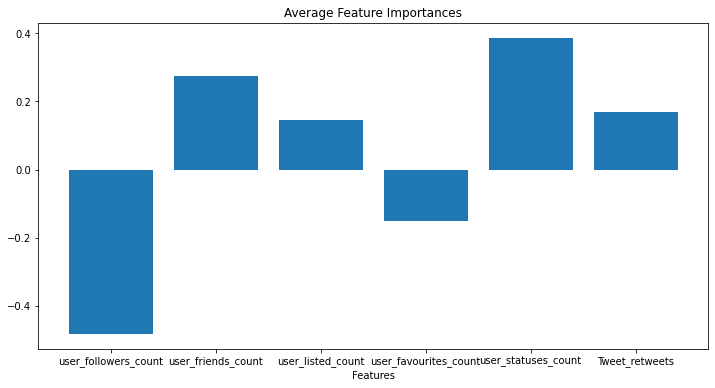

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

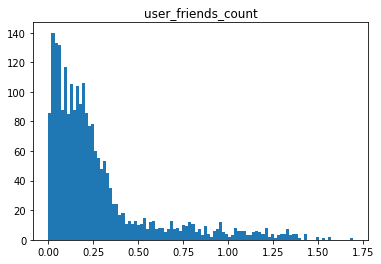

In [ ]:
plt.hist(attr[:,1], 100);
plt.title("user_friends_count");

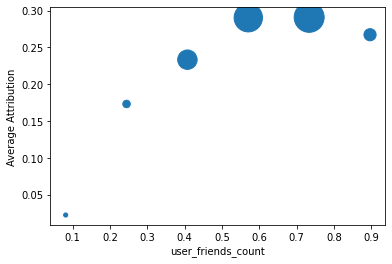

In [ ]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("user_friends_count");
plt.ylabel("Average Attribution");

In [ ]:
cond = LayerConductance(net, net.sigmoid1)
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  0.149
1 :  0.119
2 :  -0.005
3 :  -0.236
4 :  0.020
5 :  0.273
6 :  0.008


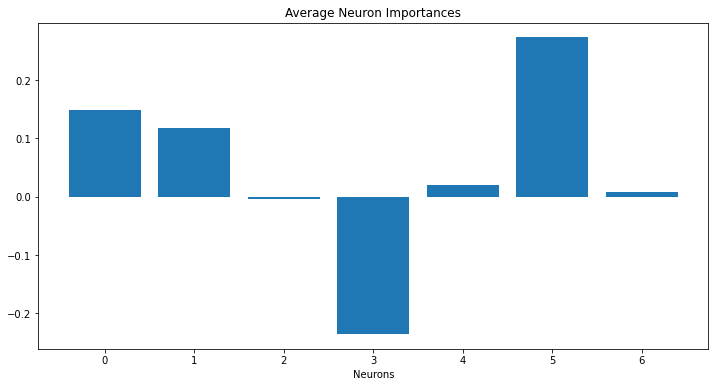

In [ ]:
visualize_importances(range(7),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

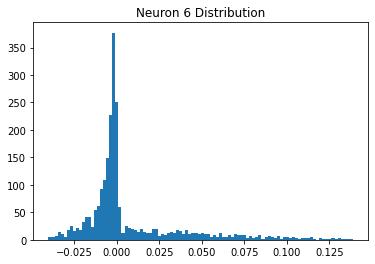

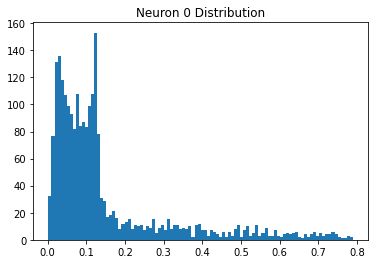

In [ ]:
plt.hist(cond_vals[:,6], 100);
plt.title("Neuron 6 Distribution")
plt.figure()
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution");

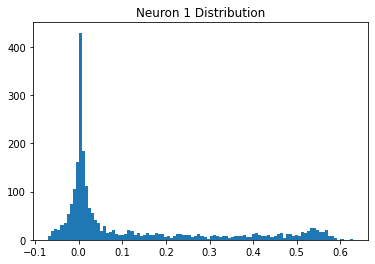

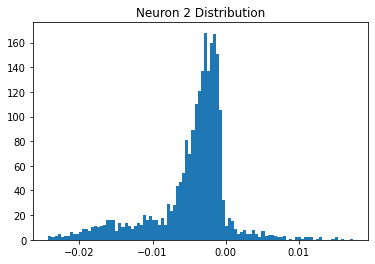

In [ ]:
plt.hist(cond_vals[:,1], 100);
plt.title("Neuron 1 Distribution")
plt.figure()
plt.hist(cond_vals[:,2], 100);
plt.title("Neuron 2 Distribution");

Average Feature Importances for Neuron 0
user_followers_count :  0.047
user_friends_count :  -0.026
user_listed_count :  0.047
user_favourites_count :  0.001
user_statuses_count :  0.086
Tweet_retweets :  -0.004
CPU times: user 2min 10s, sys: 262 ms, total: 2min 11s
Wall time: 2min 11s


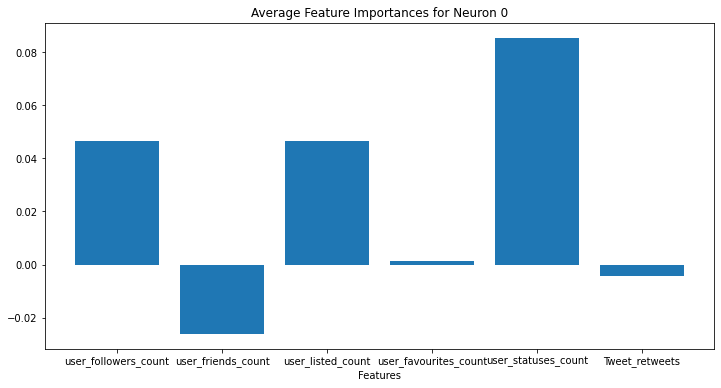

In [ ]:
%%time 

neuron_cond = NeuronConductance(net, net.sigmoid1)

neuron_cond_vals_2 = neuron_cond.attribute(test_input_tensor, neuron_index=2, target=1)

neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_index=0, target=1)

visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")


Average Feature Importances for Neuron 2
user_followers_count :  -0.004
user_friends_count :  -0.001
user_listed_count :  -0.000
user_favourites_count :  -0.003
user_statuses_count :  0.000
Tweet_retweets :  0.003


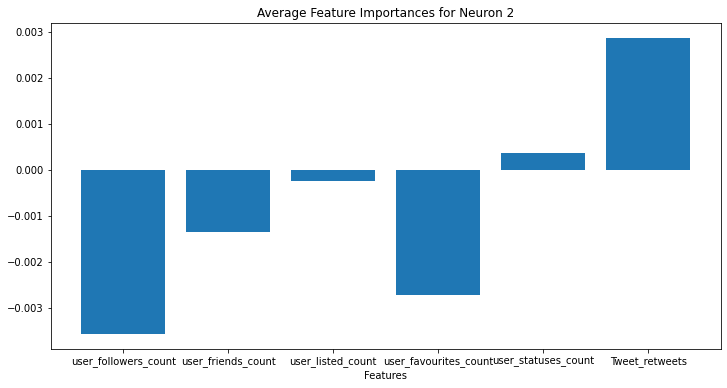

In [ ]:
visualize_importances(feature_names, neuron_cond_vals_2.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 2")


## Text Feature Exploration

In [ ]:
data_raw_text.head(3)

user_name  user_account_create  ... hashtags label
0  davepowersNYC  2009-06-13 04:03:15  ...       []   0.0
1   Katty_Kissem  2016-09-15 14:04:46  ...       []   1.0
2   maehamilton1  2011-07-02 17:22:32  ...       []   0.0

[3 rows x 6 columns]

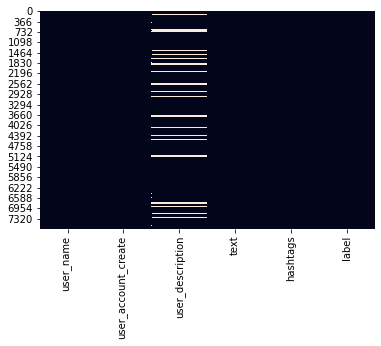

In [ ]:
sns.heatmap(data_raw_text.isnull(), cbar=False)

In [ ]:
data_raw_text.isna().sum()

user_name                 0
user_account_create       0
user_description       1117
text                      1
hashtags                  3
label                     4
dtype: int64

### User name

In [ ]:
data_raw_text["user_name"].value_counts()

AIIAmericanGirI    23
ReciteSocial       18
CcriderJohn        10
4NuNuSummer03       9
nembotavy_0101      7
                   ..
DingoDawgUSMC       1
JodyPileggi         1
gaslightingus2      1
NewsGrit            1
Bamafanaticfan1     1
Name: user_name, Length: 6724, dtype: int64

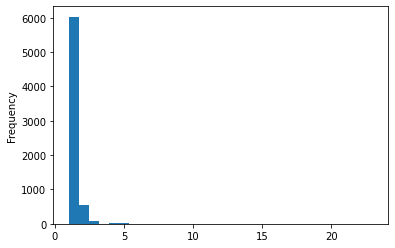

In [ ]:
data_raw_text['user_name'].value_counts().plot(
    kind='hist',
    bins=30,
    )

How many exactly are unique?

In [ ]:
len(set(np.asarray(data_raw_text["user_name"]))) 

6724

The vast majority of username are unique so this wont be a helpful feature for our classification

<a name='UserDescription' />

### User Descriptions and Tweet Body

Lets look at the user descriptions and the text body

In [ ]:
texts = [i for i in data_raw_features.text]

In [ ]:
data_raw_text["length"] = [len(str(i)) for i in texts]

In [ ]:
data_raw_text["word_count"] = [len(str(i).split()) for i in texts ]

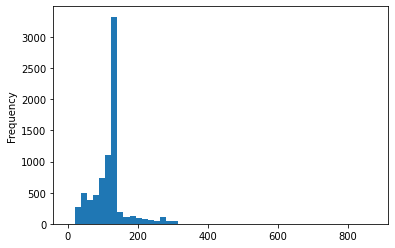

In [ ]:
data_raw_text['length'].plot(
    kind='hist',
    bins=50,
    )

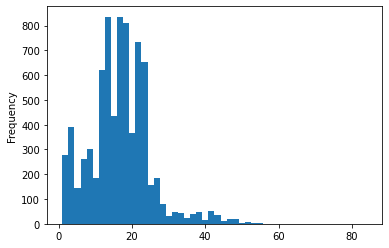

In [ ]:
data_raw_text['word_count'].plot(
    kind='hist',
    bins=50,
    )

Looks like API limiations means we can only scrape the first 140 characters from many tweets

In [ ]:
len(data_raw_text[data_raw_text.length>140]["text"])

899

There's only 1220 text bodys longer than 140 characters

<a name='Vocab' />

### Vocab Analysis

Lets have a look at the text body with no preprocessing

In [ ]:
#vocab exploration
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [ ]:
texts = data_raw_text["text"].astype(str)

In [ ]:
voc, cou = get_vocab(texts)

In [ ]:
("TOP 20: ",[(v, cou[v]) for v in voc][:20])

('TOP 20: ',
 [('RT', 4498),
  ('to', 3194),
  ('the', 2894),
  ('of', 1701),
  ('a', 1426),
  ('Trump', 1268),
  ('in', 1205),
  ('and', 1155),
  ('for', 1116),
  ('is', 1100),
  ('on', 776),
  ('that', 765),
  ('with', 630),
  ('you', 552),
  ('are', 526),
  ('The', 521),
  ('via', 485),
  ('at', 477),
  ('this', 475),
  ('I', 382)])

There seems to be a lot of stop words, user mentions and hashtags. <br>
Let's have another look at the vocab without any of these things

In [ ]:
def process_for_vocab_analysis(column, label=""):
    tick = datetime.now()

    df = data_raw_text
    
    if label:
        
        df = data_raw_text[data_raw_text["label"]==label]
        
    stg = []
    for i,doc in enumerate(df[column].astype(str)):

        mytokens_feature = text_parser(doc)
        mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                               if word.lower_ not in stopwords 
                                and word.lower_ not in punctuations
                                    and word.lower_[0] != "@" 
                                        and word.lower_[0] != "#"
                                           and word.lower_[0:2] != "rt"
                                            and word.lower_[0:6]!="https:"])
        mytokens_feature = np.asarray(mytokens_feature)
        feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )
        
        feature= " ".join([w for w in feature.split()
                             if len(w) > 1])
        
        stg.append(feature)


    #remove non english
    stg2=[]
    for i,sent in enumerate(stg):
        " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

        stg2.append(sent)
    
    tock = datetime.now()    
    print("time taken: ",tock - tick) 
    
    return stg2
    

In [ ]:
stg2 = process_for_vocab_analysis("text")

time taken:  0:00:01.959881


In [ ]:
stg3 = process_for_vocab_analysis("user_description")

time taken:  0:00:02.308216


#### Text body analysis

In [ ]:
tb_df = pd.DataFrame(sorted( dict(Counter(w for txt in stg2 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
tb_df.head(30)

word  frequency
0            trump       1798
1          ukraine        432
2             news        372
3        president        365
4              new        348
5            biden        347
6             says        284
7            house        270
8              fox        242
9            right        240
10             amp        218
11   whistleblower        212
12            like        211
13         illegal        210
14       democrats        204
15          people        203
16     impeachment        198
17        campaign        197
18      california        189
19            time        172
20           state        165
21           white        162
22          coming        155
23             end        153
24  administration        152
25         explore        145
26         clinton        143
27            apps        140
28          border        136
29        american        134

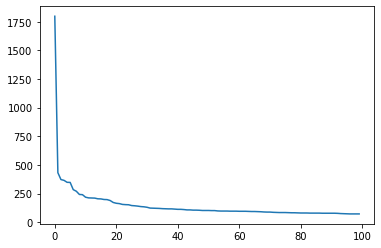

In [ ]:
tb_df['frequency'].head(100).plot(
    )

#### User description analysis

In [ ]:
ud_df = pd.DataFrame(sorted( dict(Counter(w for txt in stg3 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
ud_df.head(30)

NameError: ignored

In [ ]:
ud_df['frequency'].head(100).plot(
    )

Lets have a look if there is any difference between vocab in each class

Before doing direct comparrisons let's downsample the majority class:

In [ ]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# downsample majority
realinformation = resample(realinformation,
                              replace=True, # sample with replacement
                              n_samples=len(misinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

#### Mis information:

In [ ]:
tick = datetime.now()

column= "text"
df = misinformation

stg = []
for i,doc in enumerate(df[column].astype(str)):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#"
                                       and word.lower_[0:2] != "rt"
                                        and word.lower_[0:6]!="https:"])
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)


#remove non english
stg2=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

    stg2.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick)     

time taken:  0:00:00.767683


In [ ]:
stg2[0]

'breaking nyt second intel official alarmed trump ukraine dealings weighing file'

In [ ]:
misinfo_vocab = pd.DataFrame(sorted( dict(Counter(w for txt in stg2 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
misinfo_vocab.head(10)

word  frequency
0          trump       1400
1        ukraine        432
2          biden        327
3           news        320
4      president        289
5            new        262
6           says        246
7            fox        237
8          house        235
9  whistleblower        201

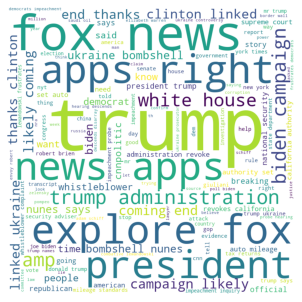

In [ ]:
words = ""

for i in stg2:
    
    for j in i.split():
    
        words += " " + j
    

            
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#### Trusted information:

In [ ]:
tick = datetime.now()

column= "text"
df = realinformation

stg = []
for i,doc in enumerate(df[column].astype(str)):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#"
                                       and word.lower_[0:2] != "rt"
                                        and word.lower_[0:6]!="https:"])
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)


#remove non english
stg3=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

    stg3.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick)     

time taken:  0:00:02.715087


In [ ]:
realinfo_vocab = pd.DataFrame(sorted( dict(Counter(w for txt in stg3 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
realinfo_vocab.head(10)

word  frequency
0    trump        319
1      via        294
2  illegal        153
3     will        152
4   people        101
5      one         97
6     time         92
7   border         90
8      new         79
9      aag         78

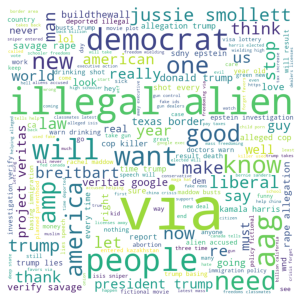

In [ ]:
words = ""

for i in stg3:
    
    for j in i.split():
    
        words += " " + j
    

            
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#### Comparrisons:

In [ ]:
realinfo_vocab.head()

word  frequency
0    trump        319
1      via        294
2  illegal        153
3     will        152
4   people        101

In [ ]:
misinfo_vocab.head()

word  frequency
0      trump       1400
1    ukraine        432
2      biden        327
3       news        320
4  president        289

In [ ]:
#word freq dicts
misinfo_freq = {}
for i,word in enumerate(misinfo_vocab["word"]):   
    misinfo_freq[word] = misinfo_vocab["frequency"][i]
    

realinfo_freq = {}
for i,word in enumerate(realinfo_vocab["word"]): 
    realinfo_freq[word] = realinfo_vocab["frequency"][i]

In [ ]:
#find common words

no = 100

c_words=[]

misinfo_words = list(misinfo_vocab["word"][0:no])
realinfo_words = list(realinfo_vocab["word"][0:no])

for word in misinfo_words[0:no]:
    
    if word in realinfo_words:
        
        c_words.append(word)


In [ ]:
common = set(c_words)
real = set(realinfo_words)
mis = set(misinfo_words)
#find set differences
uncommon_mis = mis.difference(common)
uncommon_real = real.difference(common)

In [ ]:
common_table = []

for word in list(common):
    
    common_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    
common_df = pd.DataFrame(common_table, columns = ["word","real_freq","mis_freq"])

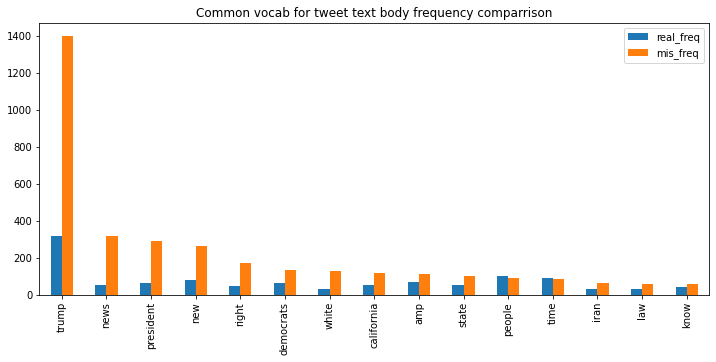

In [ ]:
lent = 15
common_df_sort = common_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = common_df_sort.plot(title = "Common vocab for tweet text body frequency comparrison" ,kind="bar",figsize=(12,5))
_=ax.set_xticklabels(common_df_sort.word)

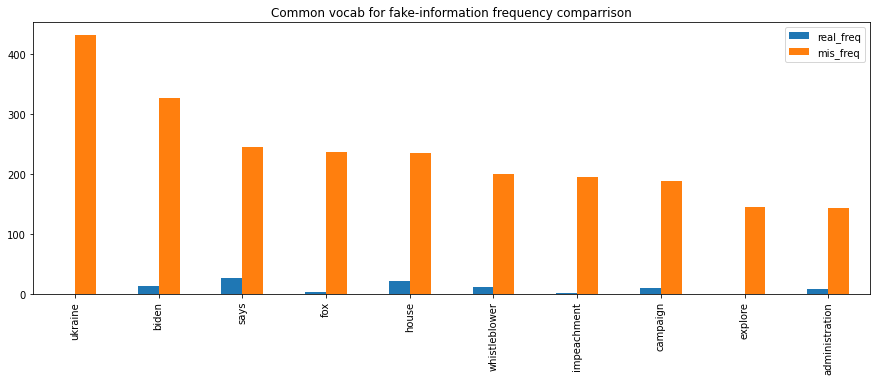

In [ ]:
uncommon_mis_table = []

for word in list(uncommon_mis):
    #print(word)
    try:
        uncommon_mis_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_mis_table.append([word, 0, misinfo_freq[word] ])
        
misinf_uncommon_df = pd.DataFrame(sorted(uncommon_mis_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 10
misinf_uncommon_df = misinf_uncommon_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = misinf_uncommon_df.plot(title = "Common vocab for fake-information frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(misinf_uncommon_df.word)

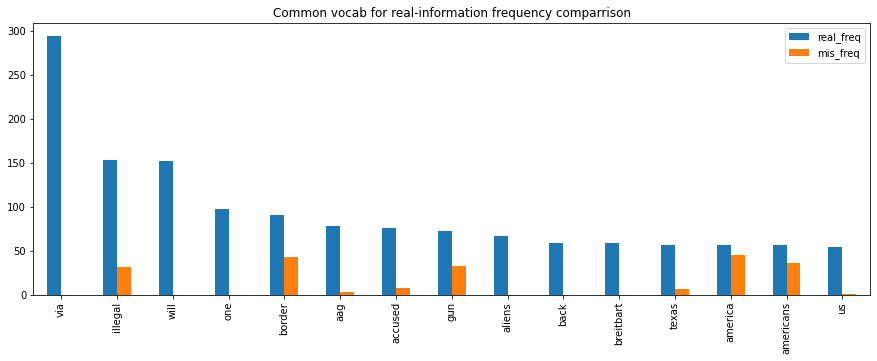

In [ ]:
uncommon_real_table = []

for word in list(uncommon_real):
    #print(word)
    try:
        uncommon_real_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_real_table.append([word, realinfo_freq[word], 0])
        
realinf_uncommon_df = pd.DataFrame(sorted(uncommon_real_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
realinf_uncommon_df = realinf_uncommon_df.sort_values(by=["real_freq"], ascending = False).head(lent)#.sample(lent)
ax = realinf_uncommon_df.plot(title = "Common vocab for real-information frequency comparrison" , kind="bar",figsize=(15,5))
_=ax.set_xticklabels(realinf_uncommon_df.word)

<br>
Now let's have a look at the hashtags and user mentions that we removed

In [ ]:
data_raw_text.head()

user_name  user_account_create  ... length word_count
0   davepowersNYC  2009-06-13 04:03:15  ...    140         16
1    Katty_Kissem  2016-09-15 14:04:46  ...    140         23
2    maehamilton1  2011-07-02 17:22:32  ...    134         20
3       slothy420  2010-05-05 14:42:54  ...    112         15
4  RestlessWestie  2016-12-12 17:12:18  ...    140         23

[5 rows x 8 columns]

Combine user desc and text body for this analysis

In [ ]:
data_raw_text["comb"] = data_raw_text["text"].astype(str) + data_raw_text["user_description"].astype(str)
texts_comb = data_raw_text["comb"]

<a name='Hashtags' />

### Hashtags

In [ ]:
text_hash = []
for i in texts_comb.astype(str):
    text_hash.append(re.findall(r"#(\w+)", i))
#or
#text_hash = [re.findall(r"#(\w+)", i) for i in texts_comb.astype(str) ]

len(text_hash)

7665

In [ ]:
data_raw_text["hashtags"] = text_hash

unique_hash=set()
hashs = []
for i in text_hash:
    for j in i:
        hashs.append(j)
        unique_hash.add(j)

In [ ]:
hastag_df = pd.DataFrame(sorted( dict(Counter(w for txt in hashs for w in txt.split())).items(), 
                                key= lambda x: -x[1]    ) ,columns=["hashtag","frequency"] )

In [ ]:
hastag_df.head(20)

hashtag  frequency
0            MAGA       1044
1             KAG        452
2              2A        277
3         WWG1WGA        240
4             NRA        196
5       Trump2020        196
6          Resist        145
7       TRUMP2020        115
8           Trump        113
9    BuildTheWall        103
10        KAG2020        101
11             1A         94
12  TheResistance         94
13            FBR         85
14   Conservative         79
15        ProLife         78
16          QAnon         78
17   AmericaFirst         71
18        Patriot         64
19  DrainTheSwamp         62

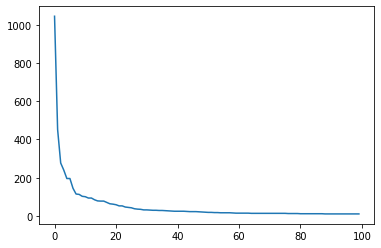

In [ ]:
hastag_df['frequency'].head(100).plot(
    )

<a name='UserMentions' />

### User Mentions

In [ ]:
text_users = [re.findall(r"@(\w+)", i) for i in texts_comb.astype(str) ]
len(text_users)

7665

In [ ]:
unique_users=set()
users = []
for i in text_users:
    if i:  
        for j in i:
            users.append(j)
            unique_users.add(j)


In [ ]:
print(len(users))
print(len(unique_users))

8878
4470


In [ ]:
mentions_df = pd.DataFrame(sorted( dict(Counter(w for txt in users for w in txt.split())).items(), 
                                key= lambda x: -x[1]    ) ,columns=["user_mention","frequency"] )

In [ ]:
mentions_df.head(20)

user_mention  frequency
0   realDonaldTrump        253
1     BreitbartNews        189
2          TheOnion        100
3   AIIAmericanGirI         87
4          GenFlynn         81
5             POTUS         78
6      kylegriffin1         55
7     SpeakerPelosi         54
8          RedState         44
9        JxhnBinder         41
10  BreitbartLondon         40
11              AOC         39
12     politicususa         36
13      mgrant76308         33
14        maggieNYT         33
15   JoeFreedomLove         32
16   ARedPillReport         30
17         CREWcrew         29
18       SenSchumer         28
19           RWPUSA         27

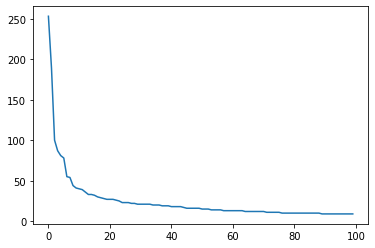

In [ ]:
mentions_df['frequency'].head(100).plot()

<a name='Punctuation' />

### Punctuation Analysis

Number of exclamation marks + question marks

In [ ]:
punc_marks = []

tick = datetime.now()

for text in texts:
    puncs = 0
    for char in text:
        if char == "?" or char == "!":
            puncs += 1
    punc_marks.append(puncs)
        
tock = datetime.now()    
print("time taken: ",tock - tick)         

time taken:  0:00:00.092338


In [ ]:
data_raw_text["puncs"] = punc_marks

In [ ]:
data_raw_text["puncs"].value_counts()[0:10]

0    6346
1     883
2     233
3     108
4      47
5      22
6      12
9       3
8       3
7       2
Name: puncs, dtype: int64

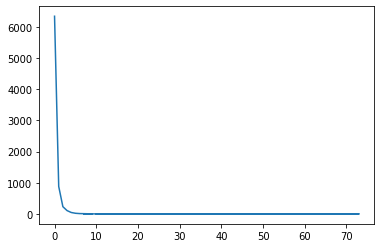

In [ ]:
data_raw_text['puncs'].value_counts().plot(
    )

In [ ]:
data_raw_text["puncs"].max()

73

Lets take a look at that anomolous row

In [ ]:
data_raw_text[data_raw_text["puncs"]==data_raw_text["puncs"].max()]

user_name  ... puncs
6223  d_fucile  ...    73

[1 rows x 10 columns]

Interesting..

<a name='Retweet' />

### Retweets

Now finally let's have a look at retweet information, we can extract this from whether a tweet starts with RT

In [ ]:
def check(i):
    if str(i)[0:2]=="RT":
        return 1
    return 0

In [ ]:
rt = [check(i) for i in data_raw_text["text"]]

In [ ]:
pd.Series(rt).value_counts()

1    4489
0    3176
dtype: int64

In [ ]:
data_raw_text["rt"] = rt

And let's analyse it in comparison to the label

In [ ]:
ct = pd.crosstab(data_raw_text['rt'], data_raw_text['label'], 
                                      margins=True)
ct

label   0.0   1.0   All
rt                     
0      1899  1273  3172
1      2300  2189  4489
All    4199  3462  7661

3462 4199
4199 4199


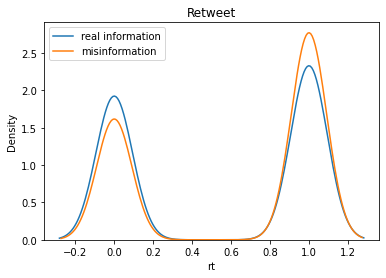

In [ ]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

fig, axes = plt.subplots(nrows=1, ncols=1)
ax = sns.kdeplot( realinformation.rt , label = 'real information')
ax = sns.kdeplot( misinformation.rt , label = 'misinformation' )
ax.legend()
_=ax.set_title("Retweet")

<a name='URLs' />

### URLS in the User Descriptions and Tweet Bodys


Now lets have a look at the domains that people have been linking in their tweets and user descriptions

The domains are all re-directed from https://t.co so we'll need to first work out where they are directed to

In [ ]:
%%time
domains_list=[]
for text in texts_comb:
    
    domains_t = []
    pattern=re.compile(r'https?://([A-Za-z_0-9.-]+).*')
    matches = re.finditer(pattern,text)
    
    for match in matches:
        
        link_sentence = match.group(0)
        domain = str(link_sentence).split()[0]
        domains_t.append(domain)
        
    domains_list.append(domains_t)

CPU times: user 37.1 ms, sys: 0 ns, total: 37.1 ms
Wall time: 39.3 ms


In [ ]:
domains_list[0:10]

[['https://t.co/ZcLvOuiJYq'],
 [],
 ['https://t.co/rqaj8YaQUt'],
 ['https://t.co/ZuAAtbJWfnOpinions'],
 ['https://t.co/4lXk6ihmbn'],
 ['https://t.co/F7t4aqJo6f'],
 ['https://t.co/GRLoENVCsyAnti'],
 ['https://t.co/8jQkazBwxq.'],
 [],
 ['https://t.co/PVIcIf7PXvWhy']]

In [ ]:
tick = datetime.datetime.now() 

redirects = []

for i,domains in enumerate(domains_list):
    
    redirects_t = []
    
    for domain in domains:
        #some of the links are broken so we have to catch exceptions
        try:
            r = requests.get(domain[0:23])
            redirects_t.append(r.url)
        except:
            redirects_t.append(domain)
    redirects.append(redirects_t)
    
    #verbose
    if i % 100 == 0:
        clear_output(wait=True)
        print(i)
        print(redirects_t)
        
tock = datetime.datetime.now()    
print("time taken: ",tock - tick)

7600
['https://abcnews.go.com/Politics/US/us-china-trade-war-forcing-farmers-2nd-jobs/story?id=66068979']
time taken:  1:04:46.723246


This might take a bit less time if you have better internet than me :) 

Let's save it the result..

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/data/redirects.pickle', 'wb') as fp:
    pickle.dump(redirects, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('redirects.pickle', 'rb') as fp:
    redirects = pickle.load(fp) 

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/data/redirects.pickle', 'rb') as fp:
    redirects = pickle.load(fp) 

In [ ]:
redirects[0:3]

[['https://politics.theonion.com/trump-administration-denies-president-was-behind-jared-1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing'],
 [],
 ['https://www.politicususa.com/2019/05/26/corrupt-foreign-donor-who-gives-to-gop-gets-62-million-in-trump-trade-war-aid.html']]

<br>
Now we've got all the re-direct links we can look at the words in these links

We want to pull out the useful info in the URL

In [ ]:
tick = datetime.datetime.now()

new_domains = []
new_domain_subs = []

for redirect_l in redirects:
    
    new_domain_subs_t = []
    new_domains_t = []
    
    for redirect in redirect_l:
        
        new_subs = []
        
        if redirect:
            
            t1 = redirect.split("/")
            new_domains_t.append(t1[2])
            
            #we only want to look from the domain (pos 2) to the end of the URL
            for subs in t1[3:len(t1)]:
                t2 = subs.split("-")
                 
                for word in t2:
                    new_subs.append(word)
                        
        new_domain_subs_t.append(new_subs)
    new_domains.append(new_domains_t)                
    new_domain_subs.append(new_domain_subs_t)
    
tock = datetime.datetime.now()    
print("time taken: ",tock - tick) 

time taken:  0:00:00.033920


In [ ]:
#test this has worked...
t = 4

print(redirects[t])
print(new_domains[t])
print(new_domain_subs[t])

['https://21stcenturywire.com/2019/04/21/why-julian-assanges-war-is-our-war-too/']
['21stcenturywire.com']
[['2019', '04', '21', 'why', 'julian', 'assanges', 'war', 'is', 'our', 'war', 'too', '']]


In [ ]:
#is it working with tweets with multiple links in...
t =25
print(redirects[t])
print(new_domains[t])
print(new_domain_subs[t])

['https://twitter.com/dougs1978/status/1095124245988937728']
['twitter.com']
[['dougs1978', 'status', '1095124245988937728']]


Looks good to me :)<br>
Now we need to add these words back into the text column so they can be used in feature extraction

In [ ]:
data_raw_text.head(2)

user_name  user_account_create  ... puncs rt
0  davepowersNYC  2009-06-13 04:03:15  ...     0  1
1   Katty_Kissem  2016-09-15 14:04:46  ...     0  1

[2 rows x 11 columns]

In [ ]:
texts_comb.head(2)

0    RT @TheOnion: Trump Administration Denies Pres...
1    RT @kylegriffin1: Breaking via NYT: A second i...
Name: comb, dtype: object

In [ ]:
new_domains[0:3]

[['politics.theonion.com'], [], ['www.politicususa.com']]

In [ ]:
new_domain_subs[0:3]

[[['trump',
   'administration',
   'denies',
   'president',
   'was',
   'behind',
   'jared',
   '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing']],
 [],
 [['2019',
   '05',
   '26',
   'corrupt',
   'foreign',
   'donor',
   'who',
   'gives',
   'to',
   'gop',
   'gets',
   '62',
   'million',
   'in',
   'trump',
   'trade',
   'war',
   'aid.html']]]

In [ ]:
stg = list(texts_comb)

for i in range(len(texts_comb)):
    
    for j in new_domains[i]:
    
        stg[i] += " "+j
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            stg[i] += " "+k
    

In [ ]:
#lets see if thats worked...
t = 3
print(redirects[t],"\n")
print(stg[t])

['https://redstate.com/alexparker/2019/05/28/finally-admits-hes-not-reporter-new-book-jim-acosta-insists-neutrality-doesnt-work-age-trump-n107974'] 

RT @marklevinshow: Acosta admits he’s not a reporter.  He’s not a serious author either. https://t.co/ZuAAtbJWfnOpinions are my own.
RT do not = endorsement redstate.com alexparker 2019 05 28 finally admits hes not reporter new book jim acosta insists neutrality doesnt work age trump n107974


In [ ]:
#lets see if thats worked...
t = 149
print(redirects[t],"\n")
print(stg[t])

['https://t.co…Trust'] 

RT @PrisonPlanet: Two more women have come forward to accuse former Vice President Joe Biden of inappropriately touching them. https://t.co…Trust no one!!  The truth IS out there!! t.co…Trust


In [ ]:
#replace the current comb column
data_raw_text["comb"] = stg

In [ ]:
data_raw_text.head()

user_name  user_account_create  ... puncs rt
0   davepowersNYC  2009-06-13 04:03:15  ...     0  1
1    Katty_Kissem  2016-09-15 14:04:46  ...     0  1
2    maehamilton1  2011-07-02 17:22:32  ...     0  1
3       slothy420  2010-05-05 14:42:54  ...     0  1
4  RestlessWestie  2016-12-12 17:12:18  ...     0  1

[5 rows x 11 columns]

Perfect!

### URL Analysis

Let's do some basic vocab analysis on the words used in the urls

In [ ]:
words = []

for i in range(len(redirects)):
    
    for j in new_domains[i]:
    
        words.append(j)
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            words.append(k)
    

In [ ]:
len(words)

65851

In [ ]:
words[0:10]

['politics.theonion.com',
 'trump',
 'administration',
 'denies',
 'president',
 'was',
 'behind',
 'jared',
 '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing',
 'www.politicususa.com']

In [ ]:
d = Counter(words)

In [ ]:
list({k: v for k, v in sorted(d.items(), key=lambda item: -item[1])}.items())[0:20]

[('2019', 2666),
 ('politics', 2537),
 ('', 1771),
 ('status', 1478),
 ('twitter.com', 1475),
 ('www.breitbart.com', 1393),
 ('trump', 1184),
 ('to', 1110),
 ('www.foxnews.com', 791),
 ('09', 526),
 ('of', 522),
 ('www.cnn.com', 480),
 ('01', 479),
 ('index.html', 474),
 ('05', 464),
 ('02', 434),
 ('03', 433),
 ('in', 407),
 ('the', 332),
 ('t.co', 315)]

In [ ]:
words = ""

for i in range(len(redirects)):
    
    for j in new_domains[i]:
    
        words += " " + j
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            words += " " + k

In [ ]:
len(words)

519729

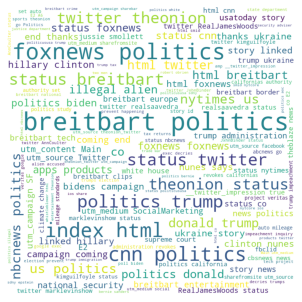

In [ ]:
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Now lets analyse the URLs used in real and fake information

In [ ]:
len(new_domains) == len(data_raw_text) == len(new_domain_subs)

True

In [ ]:
new_domains[0:10]

[['politics.theonion.com'],
 [],
 ['www.politicususa.com'],
 ['redstate.com'],
 ['21stcenturywire.com'],
 ['www.politicususa.com'],
 ['www.breitbart.com'],
 ['t.co'],
 [],
 ['www.theonion.com']]

In [ ]:
new_domain_subs[0:2]

[[['trump',
   'administration',
   'denies',
   'president',
   'was',
   'behind',
   'jared',
   '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing']],
 []]

In [ ]:
data_raw_text["domains"] = new_domains

In [ ]:
domain_str = ""

for domain in list(data_raw_text["domains"]):

    for d in domain:
        
        domain_str += " " + d

vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
vocab.head(10)

word  frequency
0           twitter.com       1475
1     www.breitbart.com       1393
2       www.foxnews.com        791
3           www.cnn.com        480
4                  t.co        308
5       www.nytimes.com        224
6       www.nbcnews.com        213
7  www.politicususa.com        142
8      www.theonion.com        109
9          redstate.com         98

In [ ]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# downsample majority
realinformation = resample(realinformation,
                              replace=True, # sample with replacement
                              n_samples=len(misinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

3462 4199
3462 3462


In [ ]:
#real info
domain_str = ""

for domain in list(realinformation["domains"]):

    for d in domain:
        
        domain_str += " " + d

realinfo_vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
realinfo_vocab.head(10)

word  frequency
0            twitter.com       1205
1      www.breitbart.com       1131
2                   t.co        165
3   www.politicususa.com        125
4       www.theonion.com         96
5            www.wnd.com         80
6           redstate.com         76
7       www.theblaze.com         67
8       www.infowars.com         66
9  www.dcclothesline.com         43

In [ ]:
#mis info
domain_str = ""

for domain in list(misinformation["domains"]):

    for d in domain:
        
        domain_str += " " + d

misinfo_vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
misinfo_vocab.head(10)

word  frequency
0   www.foxnews.com        791
1       www.cnn.com        480
2   www.nytimes.com        224
3   www.nbcnews.com        213
4              t.co        110
5  www.usatoday.com         86
6   www.cbsnews.com         61
7    abcnews.go.com         50
8       amp.cnn.com         11
9       twitter.com          4

In [ ]:
len(misinfo_vocab)

70

In [ ]:
len(realinfo_vocab)

89

In [ ]:
#word freq dicts
misinfo_freq = {}
for i,word in enumerate(misinfo_vocab["word"]):   
    misinfo_freq[word] = misinfo_vocab["frequency"][i]
    

realinfo_freq = {}
for i,word in enumerate(realinfo_vocab["word"]): 
    realinfo_freq[word] = realinfo_vocab["frequency"][i]

In [ ]:
#find common words

no = 200

c_words=[]

misinfo_words = list(misinfo_vocab["word"][0:no])
realinfo_words = list(realinfo_vocab["word"][0:no])

for word in misinfo_words[0:no]:
    
    if word in realinfo_words:
        
        c_words.append(word)

#remove the useless t.. values
c_words = [word for word in c_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]
misinfo_words = [word for word in misinfo_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]
realinfo_words = [word for word in realinfo_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]

Of the most common 200 domains, there are only 7 that appear in real and misinformation! This is an indicator that there is a heavy correlation between domain and real/misinformation.

In [ ]:
len(c_words)

5

In [ ]:
c_words

['gab.com',
 'www.youtube.com',
 'www.facebook.com',
 'www.washingtonpost.com',
 'www.amazon.com']

In [ ]:
common = set(c_words)
real = set(realinfo_words)
mis = set(misinfo_words)
#find set differences
uncommon_mis = mis.difference(common)
uncommon_real = real.difference(common)

In [ ]:
common

{'gab.com',
 'www.amazon.com',
 'www.facebook.com',
 'www.washingtonpost.com',
 'www.youtube.com'}

In [ ]:
len(uncommon_mis)

36

In [ ]:
len(uncommon_real)

52

In [ ]:
common_table = []

for word in list(common):
    
    common_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    
common_df = pd.DataFrame(common_table, columns = ["word","real_freq","mis_freq"])

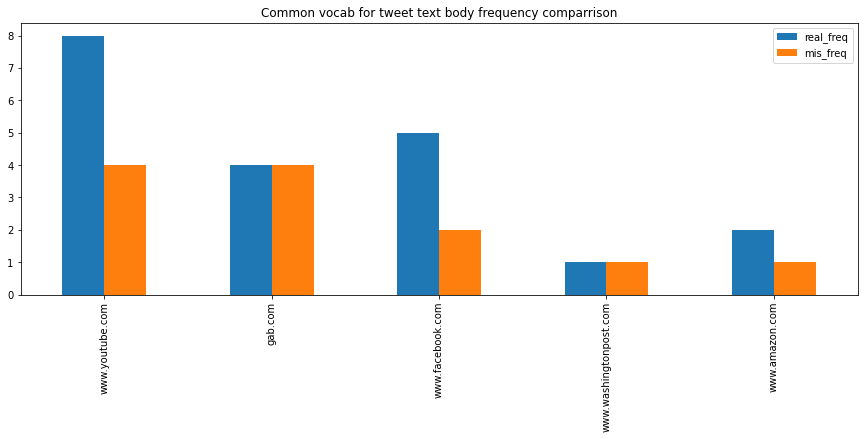

In [ ]:
lent = 15
common_df_sort = common_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = common_df_sort.plot(title = "Common vocab for tweet text body frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(common_df_sort.word)

Note: The max these links appear in either dataset is 14, which means none of these are very relevant!

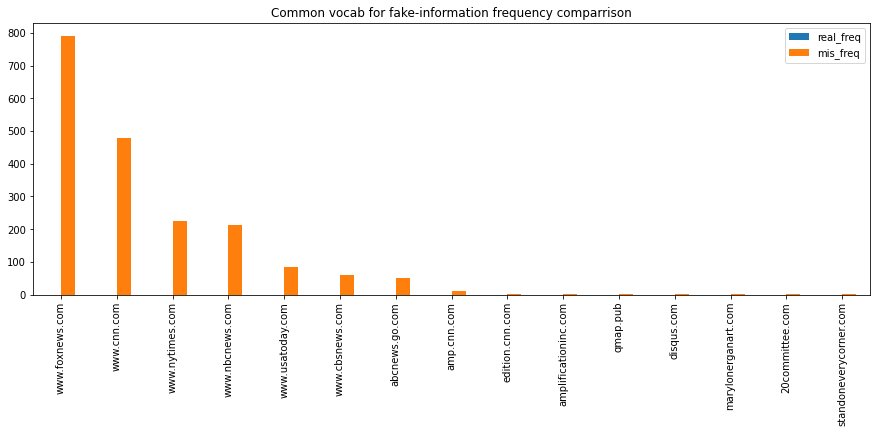

In [ ]:
uncommon_mis_table = []

for word in list(uncommon_mis):
    #print(word)
    try:
        uncommon_mis_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_mis_table.append([word, 0, misinfo_freq[word] ])
        
misinf_uncommon_df = pd.DataFrame(sorted(uncommon_mis_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
misinf_uncommon_df = misinf_uncommon_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = misinf_uncommon_df.plot(title = "Common vocab for fake-information frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(misinf_uncommon_df.word)

In [ ]:
uncommon_mis_table = []

for word in list(uncommon_mis):
    #print(word)
    try:
        uncommon_mis_table.append([word, misinfo_freq[word] ])
    except:
        uncommon_mis_table.append([word, misinfo_freq[word] ])

In [ ]:
misinf_uncommon_df = pd.DataFrame(sorted(uncommon_mis_table, key = lambda x: -x[1]), columns = ["word","mis_freq"]  ) 

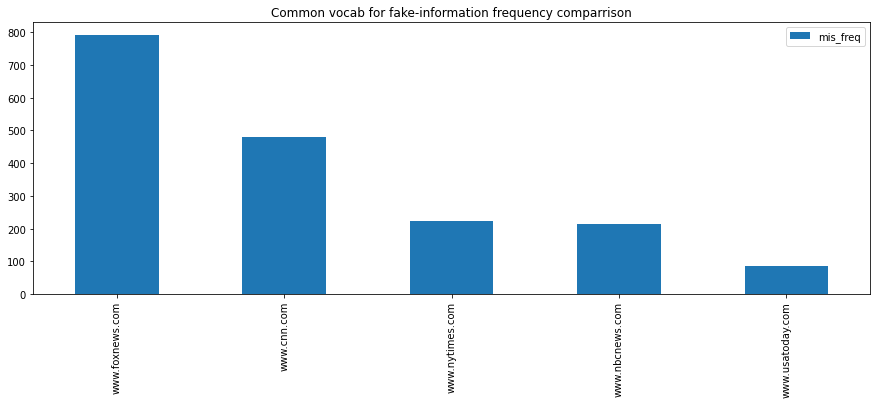

In [ ]:

lent = 5
misinf_uncommon_df = misinf_uncommon_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = misinf_uncommon_df.plot(title = "Common vocab for fake-information frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(misinf_uncommon_df.word)

In [ ]:
misinf_uncommon_df.head(lent)

word  mis_freq
0   www.foxnews.com       791
1       www.cnn.com       480
2   www.nytimes.com       224
3   www.nbcnews.com       213
4  www.usatoday.com        86

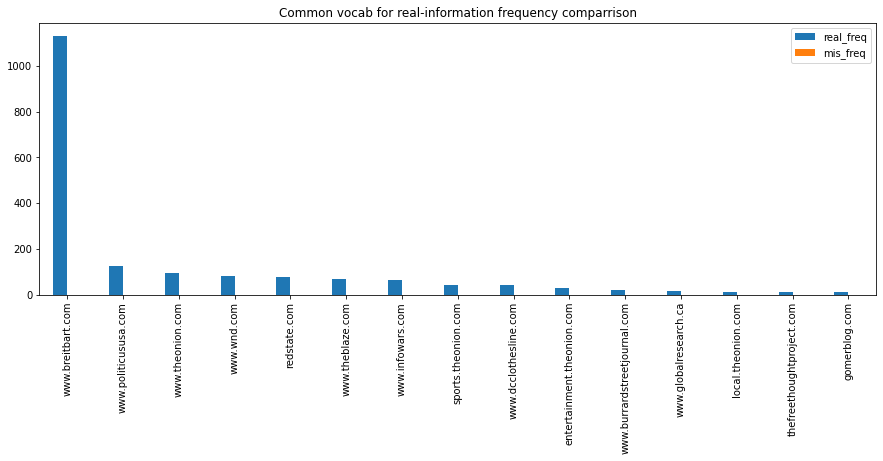

In [ ]:
uncommon_real_table = []

for word in list(uncommon_real):
    #print(word)
    try:
        uncommon_real_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_real_table.append([word, realinfo_freq[word], 0])
        
realinf_uncommon_df = pd.DataFrame(sorted(uncommon_real_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
realinf_uncommon_df = realinf_uncommon_df.sort_values(by=["real_freq"], ascending = False).head(lent)#.sample(lent)
ax = realinf_uncommon_df.plot(title = "Common vocab for real-information frequency comparrison" , kind="bar",figsize=(15,5))
_=ax.set_xticklabels(realinf_uncommon_df.word)

In [ ]:
realinf_uncommon_df.head(lent)

word  real_freq  mis_freq
30             www.breitbart.com       1131         0
33          www.politicususa.com        125         0
34              www.theonion.com         96         0
40                   www.wnd.com         80         0
42                  redstate.com         76         0
0               www.theblaze.com         67         0
43              www.infowars.com         66         0
3            sports.theonion.com         43         0
27         www.dcclothesline.com         43         0
15    entertainment.theonion.com         28         0
11  www.burrardstreetjournal.com         20         0
8          www.globalresearch.ca         17         0
12            local.theonion.com         13         0
13     thefreethoughtproject.com         12         0
5                  gomerblog.com         10         0

Wow! It looks like there is a HUGE correlation between domains linked and mis/real information! Perhaps this is one way that Twitter labelled the dataset!

### Dates

In [ ]:
parser.parse('2009-06-13 04:03:15') 

datetime.datetime(2009, 6, 13, 4, 3, 15)

In [ ]:
days= []
now = datetime.datetime.now()
dates = data_raw_text["user_account_create"].astype(str)

for c,date in enumerate(dates):  
    try:
        d1 = parser.parse(date)
        days.append((now-d1).days)
    except:
        print(c, date)
        days.append(date)
    

Looks like we've got a few rows of bad data, lets have a look at them

In [ ]:
data_raw_text.iloc[[4292,6074,13130]]

These rows are not helpful at all, there's no useful information and no label so lets remove them

In [ ]:
data_raw_text[data_raw_text["label"].isna()]

user_name  user_account_create  ... rt domains
508    SealeTeam1  2012-02-20 00:51:15  ...  0      []
509         False                 9652  ...  0      []
1865  stat_butler  2018-04-05 18:59:33  ...  0      []
6362  stat_butler  2018-04-05 18:59:33  ...  0      []

[4 rows x 12 columns]

None of these rows will be useful given they have no label so lets remove them all

In [ ]:
#create a new column
data_raw_text["days"] = days

In [ ]:
data_raw_text = data_raw_text[data_raw_text['label'].notna()]

In [ ]:
data_raw_text.reset_index(inplace=True,drop=True)

In [ ]:
data_raw_text["days"].describe()

count    7661.000000
mean     2513.497977
std      1218.815889
min       419.000000
25%      1417.000000
50%      2498.000000
75%      3576.000000
max      5011.000000
Name: days, dtype: float64

In [ ]:
data_raw_text["days"].max()

5011

In [ ]:
data_raw_text["days"].median()

2498.0

In [ ]:
data_raw_text["days"].mean()

2513.4979767654354

In [ ]:
data_raw_text["days"].min()

419

In [ ]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

3462 4199
4199 4199


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


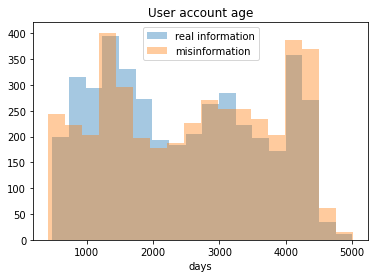

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ax = sns.distplot( realinformation.days , label = 'real information', bins=18,  kde =False)
ax = sns.distplot( misinformation.days , label = 'misinformation', bins=18, kde =False)
ax.legend()
_=ax.set_title("User account age")

Looks good to me<br>
Now lets make a new category for whether the post was made on a weekend

In [ ]:
dates = data_raw[data_raw["label"].notna()]["Tweet_created_at"].astype(str)

weekend = []
for c,date in enumerate(dates):
    try:
        d1 = parser.parse(date)
        if d1.weekday() == 5 or d1.weekday() == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    except:
        print(c, date)
        weekend.append(0)

In [ ]:
len(weekend) == len(data_raw_text)

True

Great - and getting rid of all the nan labels solved our date parsing problems

In [ ]:
data_raw_text["weekend"] = weekend

In [ ]:
ct = pd.crosstab(data_raw_text['weekend'], data_raw_text['label'], 
                 margins=True)
ct

label     0.0   1.0   All
weekend                  
0        3245  2642  5887
1         954   820  1774
All      4199  3462  7661

3462 4199
4199 4199


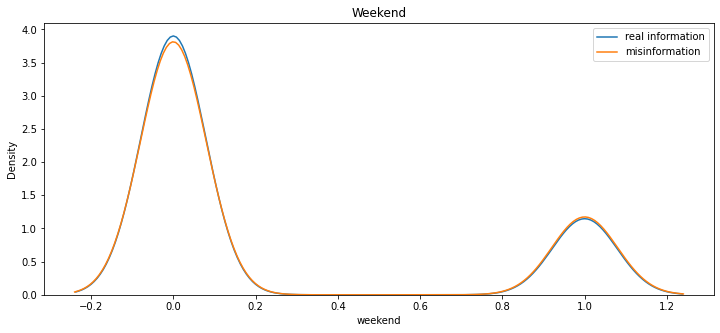

In [ ]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
ax = sns.kdeplot( realinformation.weekend , label = 'real information')
ax = sns.kdeplot( misinformation.weekend , label = 'misinformation' )
ax.legend()
_=ax.set_title("Weekend")

Looks like very little correlation

## Text Preprocessing

In [ ]:
texts = data_raw_text["comb"]

In [ ]:
#save for colab

with open('/content/drive/My Drive/Colab Notebooks/data/texts.pickle', 'wb') as fp:
    pickle.dump(texts, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
texts[0]

'RT @TheOnion: Trump Administration Denies President Was Behind Jared Kushner’s Promotion To 4-Star General https://t.co/ZcLvOuiJYq https://…Kindness. politics.theonion.com trump administration denies president was behind jared 1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing'

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    lst_text = [word for word in lst_text if not word.startswith("http") and not word.startswith("rt") and not word.startswith("@") and not word.startswith("#")]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
%%time
lst_stopwords = nltk.corpus.stopwords.words("english")
data_raw_text["processed"] = data_raw_text["comb"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))


CPU times: user 1.35 s, sys: 2 ms, total: 1.35 s
Wall time: 1.35 s


In [ ]:
data_raw_text["processed"][0]

'theonion trump administration denies president behind jared kushners promotion 4star general politicstheonioncom trump administration denies president behind jared 1832993759utm_contentmainutm_campaignsfutm_sourcetwitterutm_mediumsocialmarketing'

### Old processing dont use:

In [ ]:
 #from spacy

#9 mins on my comp

tick = datetime.now()

stg = []
for i,doc in enumerate(texts):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations 
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#" 
                                       and word.lower_[0:2] != "rt" 
                                        and word.lower_[0:6]!="https:"]) 
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)
    
    if i % 100 ==0:
        clear_output(wait=True)
        print(i)
        

#remove non english
stg2=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words) #english words from nltk
    
    if i % 100 ==0:
        clear_output(wait=True)
        print(i)
        
    stg2.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick) 

29700
time taken:  0:07:42.135728


In [ ]:
stg2[100:105]

['one cent www breitbart com clips 2019 06 19 mark levin nt intend pay one damn penny reparations anybody period',
 'jesus christ church blessed married anne priest counselor therapist usn vet corpsman uo alum twitter com theonion status 1115441972905500673',
 'kamala harris elected will take gun dealers licenses away executive action breitbart think proud american maga kag patriot trump israel trump2020 constitution followed gen flynn',
 'trump administration denies president behind jared kushner promotion star general host mma podcast scream void mma pod politics theonion com trump administration denies president behind jared 1832993759 utm_content main utm_campaign sf utm_source twitter utm_medium socialmarketing',
 'white house chief staff literally asked government scientists lie weather absolutely rid outlander fan disney fan loves family dogs']

In [ ]:
######## LOAD FROM HERE ###########

In [ ]:
#with open('/content/drive/My Drive/Colab Notebooks/data/text_processed.pickle', 'wb') as fp:
#    pickle.dump(stg2, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#data_raw_text["processed"] = stg2

In [ ]:
#with open('/content/drive/My Drive/Colab Notebooks/data/FULL_DATAFRAME.pickle', 'wb') as fp:
#    pickle.dump(data_raw_text, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
data_raw_text.sample(2)

index  ...                                          processed
3113   3116  ...  theonion passing ohio man force nation confron...
4748   4751  ...  johncardillo biased whistleblower went outside...

[2 rows x 16 columns]

### Vectorising:

We now need to create or document-term matrix which will vectorise all the processed text and ready it for model consumption

In [ ]:
min_df_no = 20
max_df_no = 10000 #not using at the moment
docs = data_raw_text["processed"]

tfidf_vec = CountVectorizer( max_features = 1800, min_df=min_df_no,binary="True", encoding='latin-1', ngram_range=(1,2), stop_words='english')
features_tfidf = tfidf_vec.fit_transform(docs)
feature_frame_count = pd.DataFrame(data = features_tfidf.todense(), columns = tfidf_vec.get_feature_names())

In [ ]:
feature_frame_count.sample(2)

01  01 06  01 15  01 20  01 23  ...  young  youre  yr  zelensky  zyrofoxtrot
7503   0      0      0      0      0  ...      0      0   0         0            0
1423   0      0      0      0      0  ...      0      0   0         0            0

[2 rows x 1800 columns]

In [ ]:
#add the retweet, days and puncs info on and we're ready
feature_frame_count["rt"] = data_raw_text["rt"]
feature_frame_count["days_no"] = data_raw_text["days"]
feature_frame_count["puncs"] = data_raw_text["puncs"]
feature_frame_count["weekend_b"] = data_raw_text["weekend"]

In [ ]:
feature_frame_count.sample()

01  01 06  01 15  01 20  ...  rt  days_no  puncs  weekend_b
3392   0      0      0      0  ...   1     1722      0          0

[1 rows x 1804 columns]

Lets min max scale days & puncs before we concat the data

In [ ]:
feature_frame_count["days_no"] -= feature_frame_count["days_no"].min()
feature_frame_count["days_no"] /= feature_frame_count["days_no"].max()
feature_frame_count["days_no"].max()

1.0

In [ ]:
feature_frame_count["puncs"] -= feature_frame_count["puncs"].min()
feature_frame_count["puncs"] /= feature_frame_count["puncs"].max()
feature_frame_count["puncs"].max()

1.0

In [ ]:
feature_frame_count.sample(5)

01  01 06  01 15  01 20  ...  rt   days_no  puncs  weekend_b
6593   0      0      0      0  ...   0  0.551394    0.0          0
2993   0      0      0      0  ...   1  0.614547    0.0          1
3536   0      0      0      0  ...   1  0.148301    0.0          0
2937   0      0      0      0  ...   1  0.271995    0.0          0
5847   0      0      0      0  ...   1  0.619120    0.0          0

[5 rows x 1804 columns]

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/data/FULL_FEATUREFRAME.pickle', 'wb') as fp:
    pickle.dump(feature_frame_count, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Concat numeric and text features

In [ ]:
#double check theyre the same length..
len(feature_frame_count) == len(data_raw_numeric_logged_scaled)

True

In [ ]:
data_raw_numeric_logged_scaled["label"]

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
7656    1.0
7657    1.0
7658    1.0
7659    0.0
7660    1.0
Name: label, Length: 7661, dtype: float64

In [ ]:
#check it hasnt been upsampled
len(data_raw_numeric_logged_scaled[data_raw_numeric_logged_scaled["label"]==1])

3462

In [ ]:
#check it hasnt been upsampled
len(data_raw_numeric_logged_scaled[data_raw_numeric_logged_scaled["label"]==0])

4199

In [ ]:
features = pd.concat([feature_frame_count, data_raw_numeric_logged_scaled ],axis=1)

In [ ]:
features = features.drop("label", axis=1)

In [ ]:
features.sample(3)

01  01 06  ...  user_statuses_count  Tweet_retweets
4746   0      0  ...             0.773414        0.000000
1119   0      0  ...             0.609442        0.391433
2287   0      0  ...             0.871810        0.152645

[3 rows x 1810 columns]

In [ ]:
features.to_csv("/content/drive/My Drive/Colab Notebooks/data/tweets_features_final.csv")

## Feature Selection

Let's do some feature selection from the text features and see if it improves our model accuracy / significantly decreases training time on a basic MLP

Some functions for our classification metrics & data prep:

### Functions for analysis

In [ ]:
def show_history(hist):
    
    #['val_loss', 'val_acc', 'loss', 'acc']
    
    fig = plt.figure()#figsize = (10,5))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('val vs train accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    fig = plt.figure()#figsize = (10,5))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('val vs train loss')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    

In [ ]:
def acc(y_test, preds):
    pred_df = pd.DataFrame(preds,columns=["pred"])
    y_test_df = pd.DataFrame(y_test).reset_index()
    model_predictions = pd.concat([y_test_df,pred_df],axis=1)
    incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
    print("Model Accuracy: ", 1 - float(len(incorrect_df)/len(model_predictions)))

In [ ]:
def conf_mat(y,pred):
    conf_mat = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
def roc(y,pred):
    lr_auc = roc_auc_score(y, pred)
    # summarize scores
    print('ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y, pred)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label='roc')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [ ]:
def report(y,pred):  
    conf_mat(y,pred)
    roc(y,pred)
    print(classification_report(y, pred))

In [ ]:
def report2(y_test,y_pred):
  sns.set(rc={'figure.figsize':(10,5)})

  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
      
  ## Accuracy, Precision, Recall
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  print("Auc:", round(auc,2))
  print("Detail:")
  print(metrics.classification_report(y_test, y_pred))
      
  ## Plot confusion matrix
  cm = metrics.confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

  fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                metrics.auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

In [ ]:
def prep_features(features):
    #pull 0.1 off for test
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=1)

    #pull 0.1 off for validate
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
    #decreases in size by 10%

    # concatenate our training data back together before upsampling
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    c1 = X[X.label==0]
    c2 = X[X.label==1]
    #print(len(c1), len(c2))

    # upsample minority
    upsampled_c2 = resample(c2,
                              replace=True, # sample with replacement
                              n_samples=len(c1), # match number in majority class
                              random_state=1) # reproducible results

    #print(len(c1),len(upsampled_c2))

    # combine majority and upsampled minority
    upsampled = pd.concat([c1, upsampled_c2])
    X_train = upsampled.sample(frac=1)#.reset_index(drop=True)
    y_train = X_train["label"]
    X_train = X_train.drop("label",axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def build_mlp(X_train, y_train, X_val, y_val, X_test, y_test):
    
    tick = datetime.datetime.now()  
    
    #decide hyper parameters: batch_size and epochs
    batch_size = 10
    epochs = 20

    #define how many inputs (num_inputs) and classes (num_classes) there are 
    num_classes = 2
    num_inputs = len(X_train.columns.values)

    # convert label class vectors to binary class matrices [0/1] -> [0 1]/ [1 0]
    train_y = keras.utils.to_categorical(y_train, num_classes)
    validate_y = keras.utils.to_categorical(y_val, num_classes)
    test_y = keras.utils.to_categorical(y_test, num_classes)

    #define model
    model1 = Sequential()
    model1.add(Dense(512, activation='relu', input_shape=(num_inputs,)))
    model1.add(Dropout(0.2))
    model1.add(Dense(512, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(num_classes, activation='softmax'))

    #model1.summary()

    #complie model
    model1.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    #define early stopping
    early_stopping = EarlyStopping(monitor = "val_accuracy", patience=3)

    #run model training
    history = model1.fit(X_train, train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0.5,
                        callbacks=[early_stopping],
                        validation_data=(X_val, validate_y))

    #evaluate model
    score = model1.evaluate(X_test, test_y, verbose=0)
    preds = model1.predict(X_test)
    y_pred_bool = np.argmax(preds, axis=1)
    
    tock = datetime.datetime.now()    
    print(tock - tick) 
    print("\n")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print("\n")
    
    return y_pred_bool, history

<a name='Upsampling' />

### Upsampling the smaller class

In [ ]:
y = data_raw_numeric["label"]

NameError: ignored

In [ ]:
len(features) == len(y)

NameError: ignored

In [ ]:
features.shape

In [ ]:
#pull 0.1 off for test
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#pull 0.1 off for validate
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
#decreases in size by 10%
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
# concatenate our training data back together before upsampling
X = pd.concat([X_train, y_train], axis=1)

In [ ]:
tick = datetime.datetime.now()
# separate minority and majority classes
c1 = X[X.label==0]
c2 = X[X.label==1]
print(len(c1), len(c2))
# upsample minority
upsampled_c2 = resample(c2,
                          replace=True, # sample with replacement
                          n_samples=len(c1), # match number in majority class
                          random_state=1) # reproducible results

print(len(c1),len(upsampled_c2))

tock = datetime.datetime.now()    
print(tock - tick)  

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([c1, upsampled_c2])
X_train = upsampled.sample(frac=1).reset_index(drop=True)
y_train = X_train["label"]
X_train = X_train.drop("label",axis=1)

In [ ]:
len(X_train)

### Control Model MLP & Naive Bayes

A base-line model with no feature selection to compare our feature selected models to:

In [ ]:
y_pred, history = build_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
show_history(history)

In [ ]:
classifier = naive_bayes.MultinomialNB()
## pipeline
model = pipeline.Pipeline([("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
#X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [ ]:
report2(y_test,y_pred)

### Chi-Squre test

We'll just do it on the doc term matrix as most of the other features we've engineered are non-categoric, also, from our previous analysis we are pretty sure they correlate with the label

In [ ]:
features.sample(2)

In [ ]:
#feature_frame_count_c2 = feature_frame_count.iloc[:,0:3432] #number of cols in the doc term matrix

In [ ]:
#len(feature_frame_count_c2.columns)

In [ ]:
#feature_frame_count_c2.sample()

In [ ]:
#ct = pd.crosstab(feature_frame_count_c2['trump'], y, 
 #                margins=True)
#ct

In [ ]:
ct = pd.crosstab(features['trump'], y, 
                 margins=True)
ct

In [ ]:
ct = pd.crosstab(features['maga'], y, 
                 margins=True)
ct

In [ ]:
tick = datetime.datetime.now()
X_new_c2 = SelectKBest(chi2, k=1000).fit_transform(features, y)
tock = datetime.datetime.now()    
print(tock - tick)  

Now we'll add the other features back in and re train the model

In [ ]:
#X_new_c2 = pd.DataFrame(X_new_c2)

In [ ]:
#X_new_c2 = pd.DataFrame(X_new_c2)
#features_c2 = pd.concat( 
    
    #concat X_new, with the extra four columns from feature_frame_count that we took out earlier
#    [X_new_c2, feature_frame_count.iloc[:,len(feature_frame_count_c2.columns): len(feature_frame_count.columns)]
     
#    ], axis = 1)

In [ ]:
#len(data_raw_numeric_logged_scaled) == len(features_c2)

In [ ]:
#add the numeric features back on
#features_c2 = pd.concat( 
    
    #concat X_new, with the extra four columns from feature_frame_count that we took out earlier
#    [features_c2, data_raw_numeric_logged_scaled.iloc[:,0:-1] ] #skip label
     
#    , axis = 1)

In [ ]:
#features_c2.sample()

Now let's use this process to perform Chi-Square using different numbers of features extracted ranging from 1000 to 3000

In [ ]:
feature_nos = [300,700,1100,1500]

ROC_scores = []

c2_preds = []

for i in feature_nos:
    print("-----------------")
    #print(i)
    
    #select best from doc term matrix
    X_new_c2 = pd.DataFrame(SelectKBest(chi2, k=i).fit_transform(features, y))
    
    #concat other features
    #features_c2 = pd.concat( 
    #    [X_new_c2, feature_frame_count.iloc[:,len(feature_frame_count_c2.columns): len(feature_frame_count.columns)]
    #        ], axis = 1)
   # 
   # features_c2 = pd.concat( 
   #     [features_c2, data_raw_numeric_logged_scaled.iloc[:,0:-1] 
   #         ], axis = 1)
    
    #test train & upsample
    X_train, y_train, X_val, y_val, X_test, y_test = prep_features(X_new_c2)
    
    #train SVC
    model = naive_bayes.MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    lr_auc = roc_auc_score(y_test, y_pred)
    print("Features", i, " ROC AUC =" ,lr_auc)
    ROC_scores.append(lr_auc)
    c2_preds.append(y_pred)

In [ ]:
plt.plot(feature_nos, ROC_scores, marker='x', label='AUC')
plt.xlabel('Number of features')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

Our peak result was extracting 2000 features

In [ ]:
report2(y_test, c2_preds[2])

In [ ]:
for i in range(len(c2_preds)) :  
    pred_df = pd.DataFrame(c2_preds[i],columns=["pred"])
    y_test_df = pd.DataFrame(y_test).reset_index()
    model_predictions = pd.concat([y_test_df,pred_df],axis=1)
    incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
    print(i, 1 - float(len(incorrect_df)/len(model_predictions)))    

This didnt outperform our baseline MLP model showing that msot of the features in the doc term matrix are useful for classification

<a name='PCA' />

### PCA

We'll perform the same test with PCA

In [ ]:
feature_frame_count_pca = features

In [ ]:
feature_nos = [300,700,1100,1500]
ROC_scores = []
PCA_preds = []

for numDimensions in feature_nos:
    print("-----------------")
    #print(i)
    
    #perform PCA
    docTermMat = np.transpose(np.asarray(feature_frame_count_pca))

    #linear algebra doc term -> lower dimensional space
    u, s, vt = np.linalg.svd(docTermMat, full_matrices=False)
    u = u[:, :numDimensions]
    sigma = np.diag(s)[:numDimensions, :numDimensions]
    #our new lower dimensional version of the docTermMatrix
    vt = vt[:numDimensions, :]

    df_lsa = pd.DataFrame(vt.T,columns=["t"+str(i) for i in range(numDimensions) ])
    #df_lsa["doc"] = text_features["processed"]
    #rearrange cols
    cols = df_lsa.columns.tolist()
    cols = cols[-1:] + cols[:-1]

    #new X_new
    X_new_PCA = df_lsa[cols]    
    
    #concat other features
    features_PCA = pd.concat( 
        [X_new_PCA, feature_frame_count.iloc[:,len(feature_frame_count_pca.columns): len(feature_frame_count.columns)]
            ], axis = 1)
    
    features_PCA= pd.concat( 
        [features_PCA, data_raw_numeric_logged_scaled.iloc[:,0:-1] 
            ], axis = 1)
    
    #test train & upsample
    X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features_PCA)
    
    #train SVC
    model_svc = LinearSVC()
    model_svc.fit(X_train, y_train)
    y_pred = model_svc.predict(X_test)
    
    lr_auc = roc_auc_score(y_test, y_pred)
    print("Features", numDimensions, " ROC AUC =" ,lr_auc)
    ROC_scores.append(lr_auc)
    PCA_preds.append(y_pred)

The accuracy has decreased here with no training time increase, so we wont use PCA

### Feature selection conclusion

None of the models outperformed our baseline MLP so we wont do any feature extraction

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features)

<a name='ModelSelection' />

## Model Selection

### Linear SVC

In [ ]:
tick = datetime.datetime.now()   

param_grid={ 
    'C':[0.01,0.1,1,10] ,  
    #'dual':[False,True]   
}
grid = GridSearchCV(LinearSVC(dual = False, max_iter = 10000, fit_intercept=True  ),param_grid,verbose=1,cv=3)

grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)
print(grid.best_params_)

tock = datetime.datetime.now()    
print(tock - tick)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.9s finished


{'C': 0.1}
0:00:03.146921


Accuracy: 0.98
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       431
         1.0       0.98      0.98      0.98       336

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



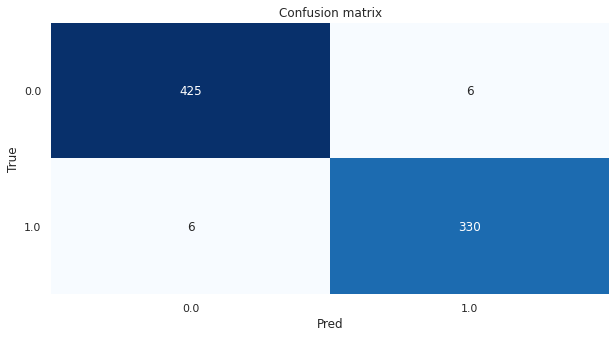

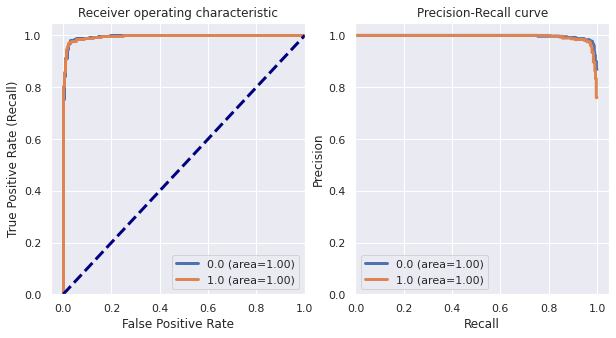

Model Accuracy:  0.984354628422425


In [ ]:
report2(y_test,grid_predictions)
acc(y_test,grid_predictions)

### MLP

In [ ]:
tick = datetime.datetime.now() 

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': [ 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    "early_stopping":[False,True]
}
grid = GridSearchCV(mlp, parameter_space, n_jobs=4, cv=5,verbose=0.5)
grid.fit(X_train, y_train)

In [ ]:
tock = datetime.datetime.now()    
print(tock - tick)

# Best paramete set
print('Best parameters found:\n', grid.best_params_)

0:13:34.539387
Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


0.978 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.979 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.979 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.978 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.978 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.978 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'sol

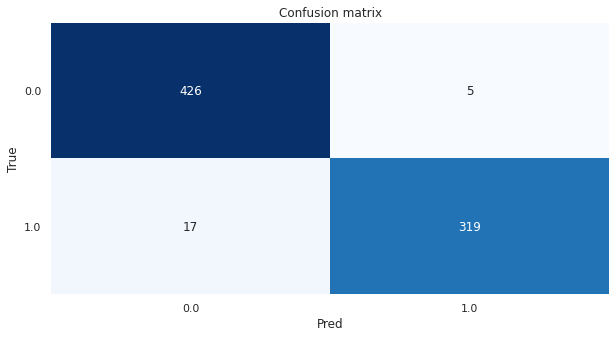

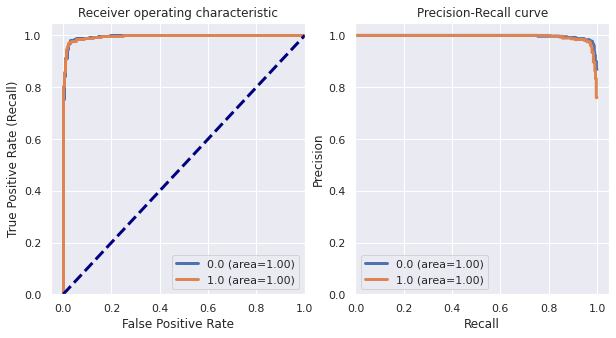

In [ ]:
# All results
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

#and finally report
grid_pred = grid.predict(X_test)
report2(y_test,grid_pred)

### Lime text interpretability


In [ ]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(data_raw_text, test_size=0.3)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer( max_features=1800, ngram_range=(1,2))

In [ ]:
corpus = dtf_train["processed"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

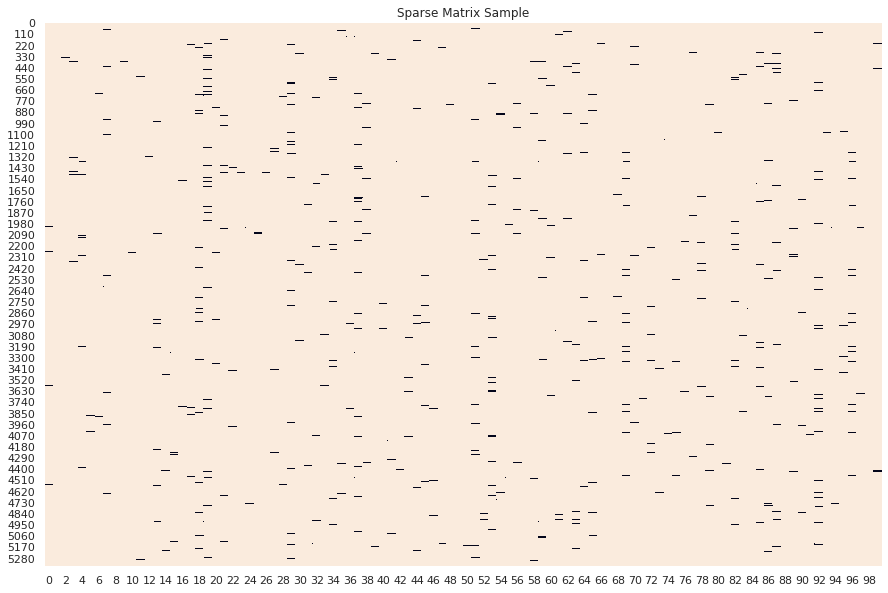

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
#choose 100 random features to display
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False ).set_title('Sparse Matrix Sample')

In [ ]:
classifier = naive_bayes.MultinomialNB()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["processed"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)


In [ ]:
np.unique(y_train)

array([0., 1.])

In [ ]:
## select observation
i = 2
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names= np.array(["Trusted","Misinformation"])) #np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=4)
explained.show_in_notebook(text=txt_instance, predict_proba=True)

True: 0.0 --> Pred: 0.0 | Prob: 1.0


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


### False Positive/ Negative Analysis

Looks like we aren't going to get much higher accuracy than this

In [ ]:
print(grid.best_params_)

{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
pred_df = pd.DataFrame(predicted,columns=["pred"])
pred_df

pred
0      1.0
1      1.0
2      0.0
3      1.0
4      1.0
...    ...
2294   0.0
2295   0.0
2296   0.0
2297   0.0
2298   0.0

[2299 rows x 1 columns]

In [ ]:
y_test_df = pd.DataFrame(y_test,columns = ["actual"]).reset_index()
y_test_df

index  actual
0         0     1.0
1         1     1.0
2         2     0.0
3         3     1.0
4         4     1.0
...     ...     ...
2294   2294     0.0
2295   2295     0.0
2296   2296     0.0
2297   2297     0.0
2298   2298     0.0

[2299 rows x 2 columns]

In [ ]:
model_predictions = pd.concat([y_test_df,pred_df],axis=1)
model_predictions

index  actual  pred
0         0     1.0   1.0
1         1     1.0   1.0
2         2     0.0   0.0
3         3     1.0   1.0
4         4     1.0   1.0
...     ...     ...   ...
2294   2294     0.0   0.0
2295   2295     0.0   0.0
2296   2296     0.0   0.0
2297   2297     0.0   0.0
2298   2298     0.0   0.0

[2299 rows x 3 columns]

Lets look at the rows in which they dont agree

In [ ]:
incorrect_df = model_predictions[model_predictions["actual"]!= model_predictions["pred"]]
incorrect_df

index  actual  pred
45       45     1.0   0.0
159     159     1.0   0.0
198     198     1.0   0.0
254     254     0.0   1.0
260     260     1.0   0.0
...     ...     ...   ...
2221   2221     0.0   1.0
2227   2227     1.0   0.0
2243   2243     0.0   1.0
2286   2286     1.0   0.0
2287   2287     1.0   0.0

[83 rows x 3 columns]

Accuracy of model:

In [ ]:
1 - float(len(incorrect_df)/len(model_predictions))

0.9638973466724663

Our false positives are where the model predicted 1 (mis information) and it was actually real information

As our test train split was pulled from the "features" dataframe, which was pulled from the "data_raw_text" so we can refer back to this as these are the indexs our test data knows

In [ ]:
#false positives: the model predicted it was misinformation but it wasnt - pred 1 actual 0
#false negatives: the model predicted that it was real information but it wasnt - pred 0 - actual 1

fp = []
fn = []

for i in incorrect_df.iterrows():
    
    indx = i[1][0]
    actual = i[1][1]
    pred = i[1][2]
    
    if pred > actual:
        fp.append(indx)
    else:
        fn.append(indx)

In [ ]:
#lets look at false positives - the model thought these were fake news but they werent
for i in fp:
    print(data_raw_text["comb"][i] + "\n")

RT @TomSteyer: At least four of these people have a Constitutional duty to protect the American people from executive over-reach⁠—instead t…Business Leader/Coach, Do the Right Thing, Family, Character & Integrity Matter. Nature has life's answers. Fan of Beautiful Game-Soccer, Barcelona, & Bosox.

RT @joncoopertweets: Mitch McConnell is among the top Republicans in Congress who are criticizing Trump's Syria decision and urging him to…mom,behavioral health administrative assistant extraordinaire, great cook,slightly humorous, northeast resister.Proud daughter of WWII Navy Vet🇺🇸

RT @steph93065: California: 20 Accused of Selling Birthright Citizenship to Pregnant Foreigners
https://t.co/LQQjMB6U1cThankful Jesus saved me. Love being a Nana to my Beautiful Granddaughter. Attended Cumberland University/Motlow College. Married 34 years #MAGA #WWG1WGA www.breitbart.com politics 2019 01 31 california 20 accused of selling birthright citizenship to pregnant foreigners 

@RepStefanik You didn't 

In [ ]:
#lets look at false negatives - the model thought these were real news but they werent 
for i in fn:
    print(data_raw_text["comb"][i] + "\n")

Apparently @redlobster doesn't care what over half its customer base stands for.  Good luck with that!  https://t.co/Tae0JnnjYkEveryone needs a soapbox🇺🇸  TRUMP 2020 www.breitbart.com politics 2019 01 08 red lobster caves to left wing blacklist campaign pulls ads from tucker carlsons show 

RT @NightlyPolitics: Jerry Nadler: “I think the President ought to be impeached' but public has to be on board”

Are you on board? I am htt…nan

RT @dbongino: Excellent piece: 👇🏻
“CIA Prepares the Blame the Consultant Excuse for Screwing the Pooch With the Steele Dossier” https://t.c…National President Trumpettes of America Mrs Highland Park 2012, Mrs Texas Fabulous Face 2014, Mrs Park Cities 2015, PR/Marketing, Prestonwood Polo Club #TOA t.c…National

RT @TracyMFinch: #DemocratslovethepeoplethathateAmericans #WALKAWAY #MAGA #VOTEHIMOUT https://t.co/0WdcfEodGBProGOD ProLife ProIsrael 🇮🇱 ConstitutionalConservative MAGA 4ALL NRA Drain The Swamp PARLER- NancyJ   TRUMP2020🇺🇸 www.breitbart.com clips 2019

### Word2vec

In [ ]:
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/tweets_features_final.csv")

In [ ]:
cols = [0]
features.drop(features.columns[cols],axis=1,inplace=True)

In [ ]:
features.head()

01 06  01 15  ...  user_statuses_count  Tweet_retweets
0      0      0  ...             0.829657        0.717026
1      0      0  ...             0.682504        0.833094
2      0      0  ...             0.862391        0.000000
3      0      0  ...             0.738983        0.744237
4      0      0  ...             0.622577        0.065741

[5 rows x 1809 columns]

In [ ]:
dtf = pd.read_csv("./drive/My Drive/Colab Notebooks/data/twitter_data_text_cleaned_no_duplicates.csv")

In [ ]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
corpus = dtf_train["text_clean"]
corpus = [str(i) for i in corpus]
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
input_length = 15
vector_length = 300
nlp = gensim_api.load("word2vec-google-news-300")

In [ ]:
## fit w2v
input_length = 15
vector_length = 300
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=vector_length,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer( lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=input_length, padding="post", truncating="post")

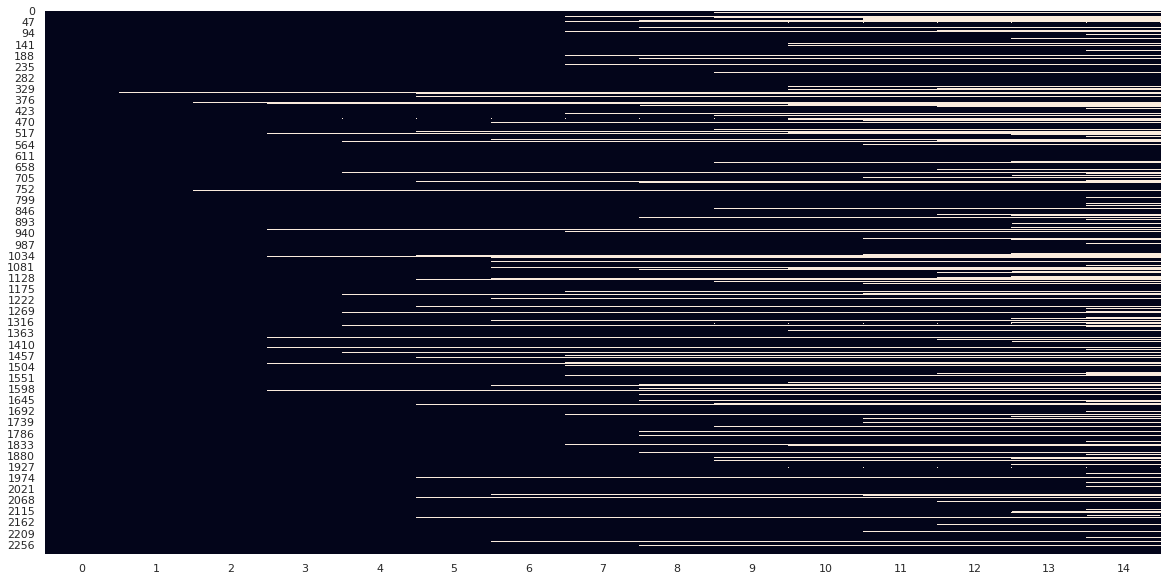

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()
#shows how long all the tweets are

In [ ]:
i = 4

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  faith family farming trucking love nascar spending time kid granddaughter occasional trip casino unbelievable | len: 14
to:  [  21 3229   48  890  129 3230   43 2344 2345  258 2346 3231 1216 3232
 1825] | len: 15
check:  faith  -- idx in vocabulary --> 595
vocabulary:  {'NaN': 1, 'trump': 2, 'nan': 3, 'maga': 4, 'u': 5} ... (padding element, 0)


In [ ]:
#TEST SET

corpus = dtf_test["text_clean"]
corpus = [str(i) for i in corpus]
## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=input_length,
             padding="post", truncating="post")

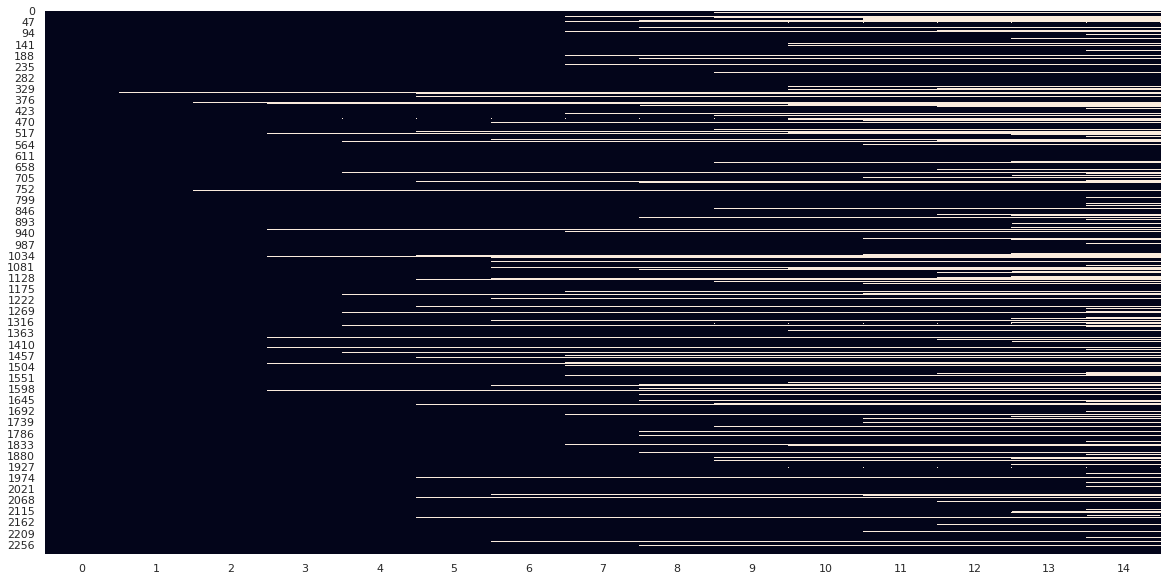

In [ ]:
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s

embeddings = np.zeros((len(dic_vocabulary)+1, vector_length))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
embeddings.shape

(12837, 300)

In [ ]:
word = "trump"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 2 |idx
embeddings[idx]: (300,) |vector


In [ ]:
K.clear_session()

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      3851100     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
_______________________________________________________________________________________

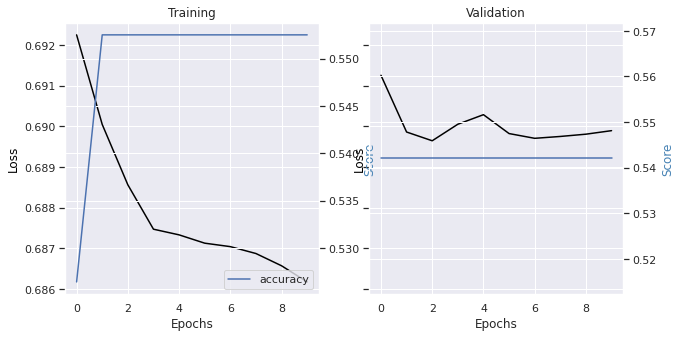

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})

## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics_t = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics_t:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics_t:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
#auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
#print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

TypeError: ignored

### BERT/ TRANSFORMER


### MLP


#### Keras

In [ ]:
y_pred, history = build_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

Train on 32540 samples, validate on 2676 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
0:21:40.308386


Test loss: 0.07681639818061446
Test accuracy: 0.9929364276702181




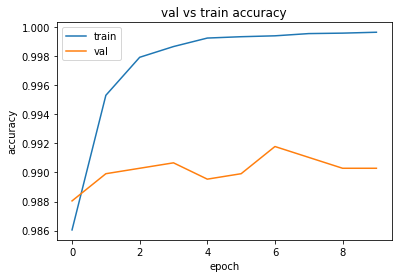

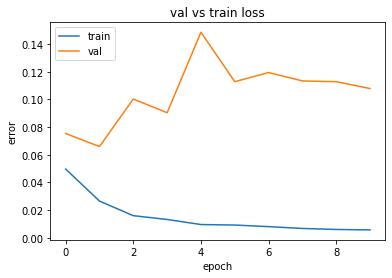

In [ ]:
show_history(history)

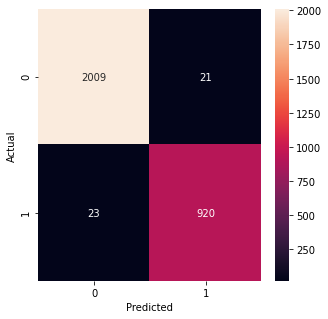

ROC AUC=0.983


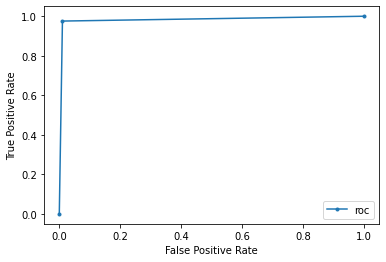

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.99      0.99      0.99      2973



In [ ]:
report(y_test, y_preds)

<a name='Sci-kitLearn' />

#### Sci-kit

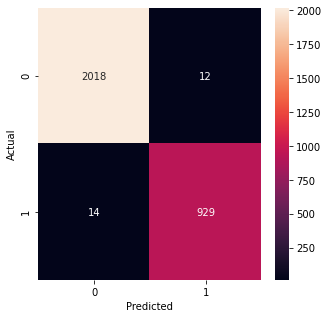

ROC AUC=0.990


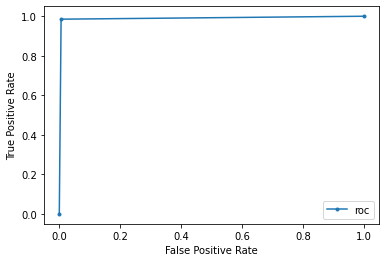

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.99      0.99      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [ ]:
mlp = MLPClassifier(max_iter=100)
mlp.fit(X_train, y_train)
y_preds = mlp.predict(X_test)
report(y_test,y_preds)

In [ ]:
acc(y_test,y_preds)

Model Accuracy:  0.9912546249579549


<a name='SVM' />

### Support Vector Machine

In [ ]:
tick = datetime.now()  

model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

0:00:14.305649


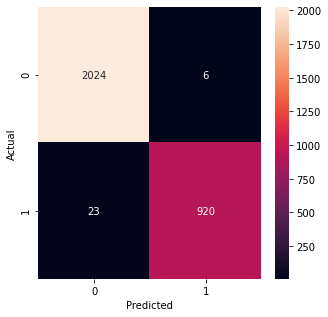

ROC AUC=0.986


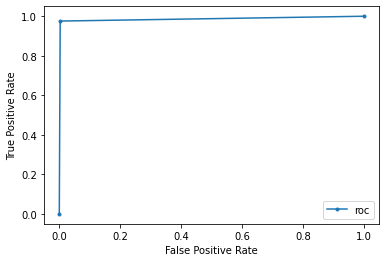

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [ ]:
report(y_test, y_pred)

In [ ]:
acc(y_test,y_pred)

Model Accuracy:  0.9902455432223344


<a name='DecisionTree' />

### Decision Tree

0:00:26.262376


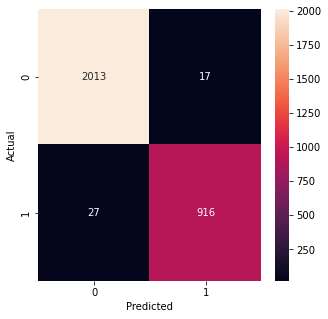

ROC AUC=0.981


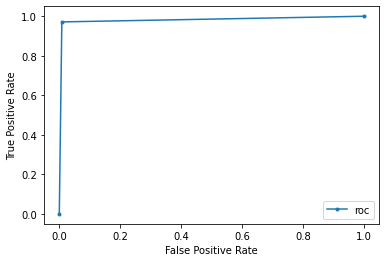

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.97      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.99      0.99      0.99      2973



In [ ]:
# Make a decision tree and train
tick = datetime.now()

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

report(y_test, y_pred)

In [ ]:
acc(y_test,y_pred)

Model Accuracy:  0.9852001345442314


<a name='RandomForest' />

### Random Forest

0:00:51.354818


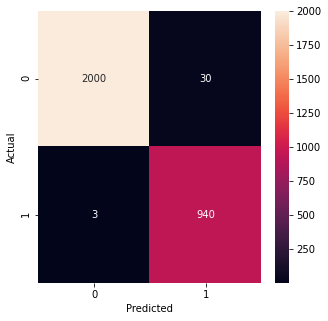

ROC AUC=0.991


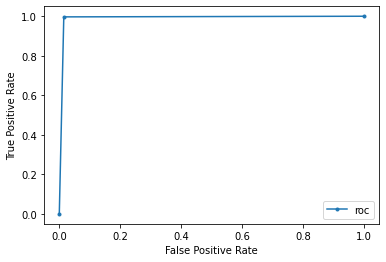

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2030
         1.0       0.97      1.00      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973

Model Accuracy:  0.9889001009081736


In [ ]:
tick = datetime.now() 
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

report(y_test, y_pred)

acc(y_test,y_pred)

<a name='Hyperparameter' />

## Hyper Parameter tuning (with GridSearch)

Lets do some tuning on the best couple of models to see if we can improve them

<a name='SVM2' />

### SVM Gaussian

In [ ]:
tick = datetime.now()  

model_svc = SVC(kernel="rbf",gamma="auto")
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

0:41:11.211727


In [ ]:
acc(y_test, y_pred)

Model Accuracy:  0.937773292970064


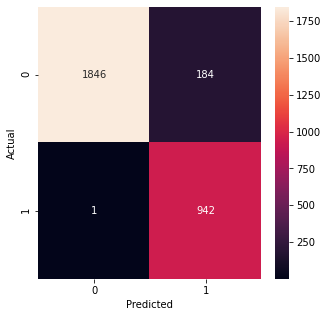

ROC AUC=0.954


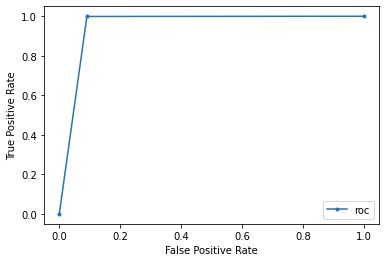

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      2030
         1.0       0.84      1.00      0.91       943

    accuracy                           0.94      2973
   macro avg       0.92      0.95      0.93      2973
weighted avg       0.95      0.94      0.94      2973



In [ ]:
report(y_test, y_pred)

### SVM 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min finished


{'C': 1}
0:01:44.023669


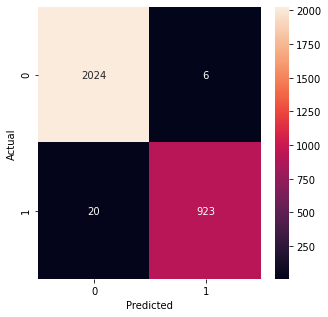

ROC AUC=0.988


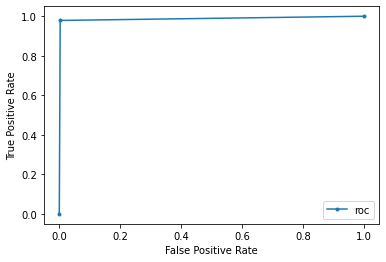

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973

Model Accuracy:  0.9912546249579549


In [ ]:
tick = datetime.now()   

param_grid={ 
    'C':[0.1,1,10] ,  
    #'dual':[False,True]   
}
grid = GridSearchCV(LinearSVC(dual = False, max_iter = 10000, fit_intercept=True  ),param_grid,verbose=1,cv=3)

grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)
print(grid.best_params_)

tock = datetime.now()    
print(tock - tick)

report(y_test,grid_predictions)
acc(y_test,grid_predictions)

<a name='MLP2' />

### MLP 

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features)

16270 7809
16270 16270


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed: 56.7min
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 293.8min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed: 700.5min finished


11:42:55.212832
Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.996 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 

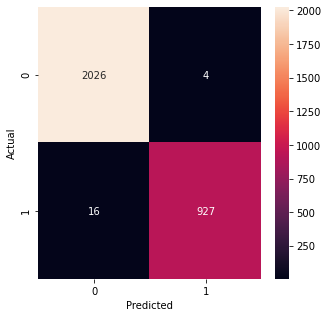

ROC AUC=0.991


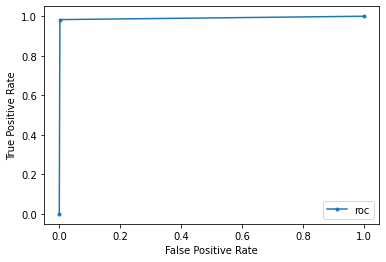

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2030
         1.0       1.00      0.98      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [ ]:
tick = datetime.now() 

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    "early_stopping":[False,True]
}
grid = GridSearchCV(mlp, parameter_space, n_jobs=4, cv=5,verbose=0.5)
grid.fit(X_train, y_train)

tock = datetime.now()    
print(tock - tick)

# Best paramete set
print('Best parameters found:\n', grid.best_params_)

# All results
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

#and finally report
grid_pred = grid.predict(X_test)
report(y_test,grid_pred)

In [ ]:
best_params = {'activation': 'relu', 'alpha': 0.05, 
               'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 
               'learning_rate': 'constant', 'solver': 'adam'}

<a name='FalsePositive' />